# Sea ice deformation from the ice floe tracker measurements
The deformation analysis from the IFT measurements adapts methods based on buoy ice tracking for the new context. Rather than a few velocity time series that sample a location over a long period of time, we have many time series sampling many locations over short periods of time. This notebook contains analyses beyond what is presented in the paper.

## Contents
1. Polygon selection methods
2. Calculating deformation (invariants of the strain-rate tensor)
3. Uncertainty in deformation
5. Performance of the log-normal MLE
6. Comparison with the results of fitting a line to bin means
7. Possibilities of floe interaction effects at small scales

# Polygon selection
The deformation analysis is based on estimating area-average deformation within triangles formed with ice floes as the vertices. We identify all possible triangles formed by sea ice floes within each image, and rejected those with minimum angle less than 20 degrees. Using all possible triangles results in considerable overlap between triangles, which could be leveraged for making smoothed estimates of deformation properties at particular length scales. Where this dataset offers an advantage relative to methods used for buoy analysis is that we can leverage the large number of data points to create a set of triangles covering all length scales, without overlap in triangles areas. Another option would be to use triangles with no shared vertices, and allow overlap between triangles. We show both options in the figure below.

For the analysis in the paper, the sampling is as follows:
1. Select all polygons with minimum interior angle greater than 20
2. Set a maximum number per bin per month (1000) and a maximum per date (10)
3. Shuffle the list of dates
4. For each date, group by bin, then shuffle the bin numbers.
5. Shuffle the list of polygons within the bin
6. One by one, compare the polygons to the other polygons selected for that date (all bin numbers)
7. If no overlaps of more than 1 pixel, then add to the list of polygons and increment the number of polygons selected
8. Continue until maximum number is reached or no more polygons left

This produces a larger-than-used sample, which is then downsampled to 500 per bin weighted by date for estimation of the power law slopes.

In [1]:
import proplot as pplt
import pandas as pd
import numpy as np
import pyproj
import powerlaw
from shapely.geometry import Point, Polygon

In [3]:
# Load and clean trajectories
ift_data = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv')
ift_data['datetime'] = pd.to_datetime(ift_data['datetime'])
init_n = len(ift_data)

In [4]:
# Load deformation data
df = pd.read_csv('../data/deformation/sampled_results.csv', index_col=0)
df['datetime'] = pd.to_datetime(df['datetime'])

# Define logarithmically spaced bins
logbins = np.logspace(np.log(10), np.log(300), base=np.e, num=10)
df['L'] = np.sqrt(df['polygon_area'])
df['log_bin'] = np.digitize(df['L'], logbins)

date = pd.to_datetime('2013-04-24 12:00:00')
df_date = df.loc[df.datetime == date]
traj_date = ift_data.loc[ift_data.datetime == date]

## Example image: Unique Floes vs. No Overlap

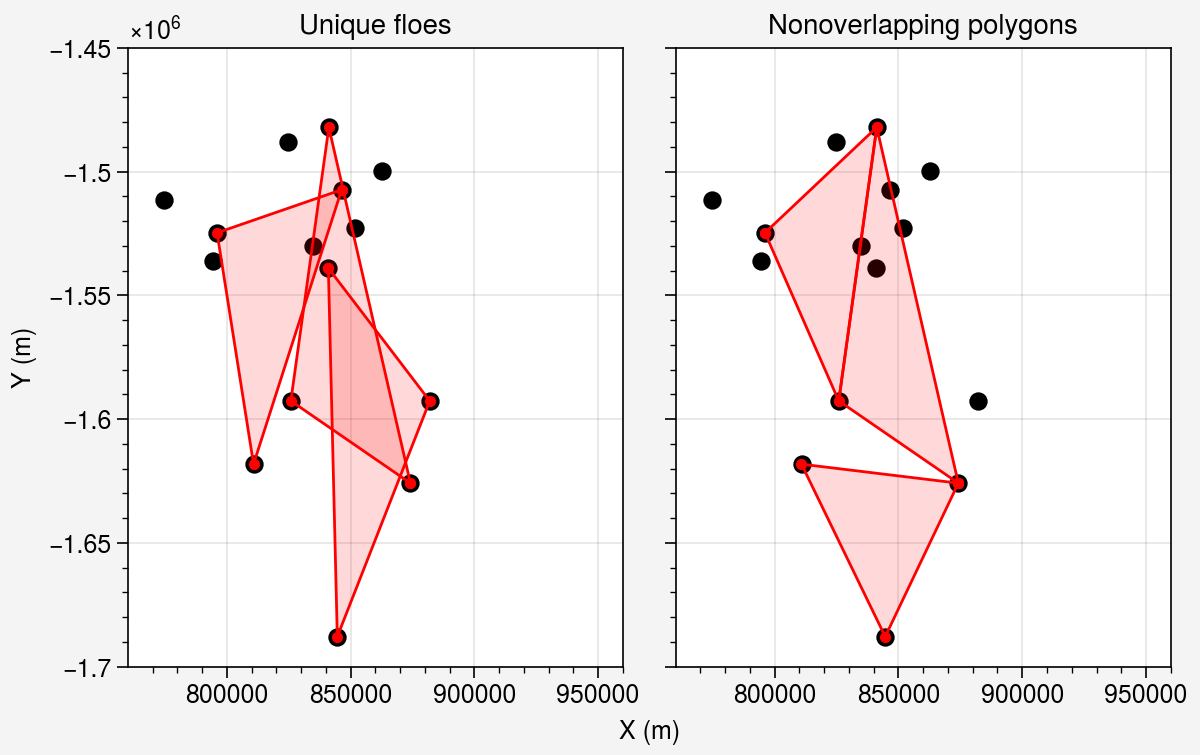

In [5]:
fig, axs = pplt.subplots(width=6, aspect=1, ncols=2)
for ax, sample_type in zip(axs, ['unique_floes_sample', 'no_overlap_sample']):
    for color, lb in zip(['r', None], [5]):
        df_bin = df_date.loc[df_date.log_bin == lb]
        polygons_init = []
     
        samples = []
        for row, data in df_bin.loc[df_bin[sample_type], :].iterrows():
            samples.append(Polygon([Point(x, y) for x, y in zip([data.x1, data.x2, data.x3],
                                                        [data.y1, data.y2, data.y3])]))
        
        ax.scatter(traj_date.x_stere.values, traj_date.y_stere.values, marker='o', color='k')
        # ax.scatter(df_date.x1.values, df_date.y_stere.values, marker='*', color='b', zorder=5)
        for p in polygons_init:
            ax.plot(*p.exterior.xy, color='k', lw=0.5, marker='', alpha=0.25)
            ax.plot(*p.exterior.xy, color='k', lw=0, marker='.')
        
        # colors = [c['color'] for c in pplt.Cycle('spectral', 5)]
        
        # for c, p in zip(colors*int(len(samples)/5), samples):
        for p in samples:
            ax.plot(*p.exterior.xy, lw=1, zorder=2, alpha=1, c=color, marker='.')
            ax.fill(*p.exterior.xy, lw=0, zorder=2, alpha=0.15, c=color)
        ax.format(ylim=(-1.7e6, -1.45e6), xlim=(0.76e6, 0.96e6))
    axs[0].format(title='Unique floes', xlabel='X (m)', ylabel = 'Y (m)')
    axs[1].format(title='Nonoverlapping polygons')

## Possibility of non-overlap across scales
* Full dataset is 4,228,491 polygons

In [109]:
# Loading data
data = []
years = []
all_data = []
for year in range(2003, 2021):
    results = pd.read_csv('../data/deformation/polygons_' + str(year) + '.csv')
    results = results.dropna(subset=['u1', 'u2', 'u3'])
    results.rename({'Unnamed: 0': 'datetime', 'Unnamed: 1': 'triangle_number'}, axis=1, inplace=True)
    results['datetime'] = pd.to_datetime(results['datetime'].values)
    
    results['L'] = np.sqrt(results['polygon_area'])
    results['log_bin'] = np.digitize(results['L'], logbins)
    all_data.append(results)
    years.append(year)
    data.append(results.groupby('log_bin').count()['datetime'].values)
df_info = pd.DataFrame(data, index=years)

all_results = pd.concat(all_data, axis=0)
all_results.reset_index(drop=True, inplace=True)

In [113]:
# get xcoords
projIn = 'epsg:4326' # WGS 84 Ellipsoid
projOut = 'epsg:3413' # NSIDC North Polar Stereographic
transformer_ps = pyproj.Transformer.from_crs(projIn, projOut, always_xy=True)

for idx in range(1, 4):
    x, y = transformer_ps.transform(all_results['lon' + str(idx)], all_results['lat' + str(idx)])
    all_results['x' + str(idx)] = x
    all_results['y' + str(idx)] = y

all_results['month'] = all_results['datetime'].dt.month
all_results['year'] = all_results['datetime'].dt.year

all_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4228491 entries, 0 to 4228490
Data columns (total 42 columns):
 #   Column             Dtype         
---  ------             -----         
 0   datetime           datetime64[ns]
 1   triangle_number    int64         
 2   floe1              object        
 3   floe2              object        
 4   floe3              object        
 5   u1                 float64       
 6   u2                 float64       
 7   u3                 float64       
 8   v1                 float64       
 9   v2                 float64       
 10  v3                 float64       
 11  lat1               float64       
 12  lat2               float64       
 13  lat3               float64       
 14  lon1               float64       
 15  lon2               float64       
 16  lon3               float64       
 17  area_km21          float64       
 18  area_km22          float64       
 19  area_km23          float64       
 20  zeta1              float

In [123]:
print(bin_counts_date)
for bin_number in bin_counts_date.sample(frac=1, replace=False).index:
    print(bin_number)

log_bin
0    1
5    6
6    1
Name: L, dtype: int64
6
5
0


In [2]:
def normal_log_likelihood(eps, L, beta):
    n = len(eps)
    data = np.log(eps*L**beta)
    mu = np.mean(data)
    sigma = np.std(data)
    normalizer = -n/2*np.log(2*np.pi*sigma**2)
    return normalizer - np.sum(data - mu)**2/(2*sigma**2)

In [181]:
%time
# Non-overlapping polygons
# 1. Randomly select first triangle and make a Shapely polygon. Set 'no_overlap_sample' to True
# 2. Check whether the intersection with the next triangle is nonzero. If so, add sample to list
all_results['no_overlap_sample'] = False 
bin_counts = {x: 0 for x in range(0, 11)}
n_per_bin = 500
tol = 1 # number of pixels in the overlap

import warnings
warnings.simplefilter('ignore')

for date, date_group in all_results.loc[all_results.month == 4].groupby('datetime'):
    print(date, len(date_group))
    # initialize list for the date
    sampled_polygons = []
    sampled_row_keys = []
    
    # shuffle order of bins for sampling
    random_state = pd.to_datetime(date).year*1000 + pd.to_datetime(date).dayofyear
    bin_counts_date = date_group.groupby('log_bin').count()['L'].sample(frac=1, replace=False, random_state=random_state)
    
    for bin_number in bin_counts_date.index:
        
        if bin_counts[bin_number] <= n_per_bin:
            polygons = []
            row_keys = []

            random_state = pd.to_datetime(date).year*1000 + pd.to_datetime(date).dayofyear + bin_number
            df_bin = date_group.loc[date_group.log_bin == bin_number].copy()
        
            # Shuffle the order then make a list of polygons and rows
            for row, data in df_bin.sample(frac=1, replace=False, random_state=random_state).iterrows():                
                polygons.append(Polygon([Point(x, y) for x, y in zip([data.x1, data.x2, data.x3],
                                                            [data.y1, data.y2, data.y3])]))
                row_keys.append(row)
                
            # With this list in for the chosen bin, check for intersections. 
            for r, p in zip(row_keys, polygons):
                if bin_counts[bin_number] < n_per_bin:
                    if not any(p.intersection(g).area > tol for g in sampled_polygons):
                        sampled_polygons.append(p)
                        sampled_row_keys.append(r)
                        bin_counts[bin_number] += 1
        all_results.loc[sampled_row_keys, 'no_overlap_sample'] = True
    
columns = ['datetime', 'triangle_number', 'floe1', 'floe2', 'floe3', 'u1', 'u2',
           'u3', 'v1', 'v2', 'v3', 'x1', 'x2', 'x3', 'y1', 'y2', 'y3',
           'area_km21', 'area_km22', 'area_km23', 'zeta1', 'zeta2', 'zeta3',
           'edge_dist_km1', 'edge_dist_km2', 'edge_dist_km3', 'coast_dist_km1',
           'coast_dist_km2', 'coast_dist_km3', 'polygon_area', 'min_angle', 'L', 'log_bin',
           'divergence', 'vorticity', 'pure_shear', 'normal_shear', 'maximum_shear_strain_rate', 'total_deformation',
           'no_overlap_sample', 'unique_floes_sample']

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs
2003-04-02 12:00:00 8
2003-04-03 12:00:00 15
2003-04-04 12:00:00 7
2003-04-06 12:00:00 3
2003-04-07 12:00:00 3
2003-04-13 12:00:00 1
2003-04-14 12:00:00 100
2003-04-15 12:00:00 154
2003-04-16 12:00:00 169
2003-04-17 12:00:00 133
2003-04-18 12:00:00 189
2003-04-19 12:00:00 1356
2003-04-20 12:00:00 2236
2003-04-21 12:00:00 3975
2003-04-22 12:00:00 2650
2003-04-23 12:00:00 1103
2003-04-24 12:00:00 1117
2003-04-25 12:00:00 1793
2003-04-26 12:00:00 829
2003-04-27 12:00:00 186
2003-04-28 12:00:00 208
2003-04-29 12:00:00 1102
2003-04-30 12:00:00 2036
2005-04-01 12:00:00 257
2005-04-02 12:00:00 403
2005-04-07 12:00:00 1
2005-04-08 12:00:00 1
2005-04-09 12:00:00 11
2005-04-10 12:00:00 59
2005-04-11 12:00:00 47
2005-04-13 12:00:00 1
2005-04-14 12:00:00 1
2005-04-17 12:00:00 10
2005-04-18 12:00:00 1445
2005-04-19 12:00:00 3210
2005-04-20 12:00:00 3462
2005-04-21 12:00:00 6755
2005-04-22 12:00:00 7366
2005-04-23 12:00:00 5875
2005

<AxesSubplot:xlabel='datetime'>

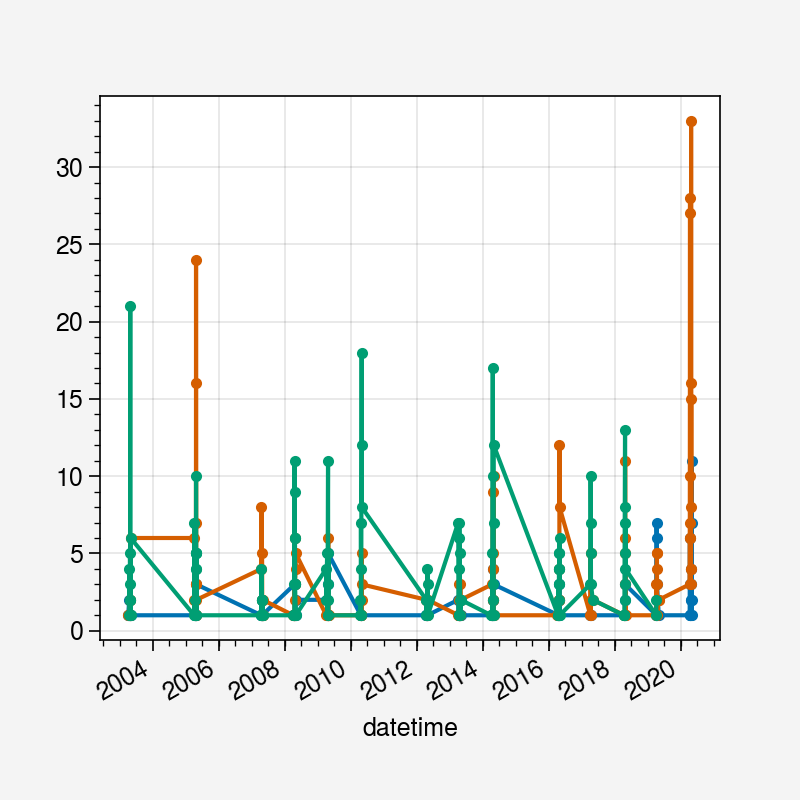

In [182]:
all_results.loc[all_results.no_overlap_sample].groupby(['log_bin', 'datetime']).count()['triangle_number'][0].plot(marker='.')
all_results.loc[all_results.no_overlap_sample].groupby(['log_bin', 'datetime']).count()['triangle_number'][1].plot(marker='.')
all_results.loc[all_results.no_overlap_sample].groupby(['log_bin', 'datetime']).count()['triangle_number'][2].plot(marker='.')

In [183]:
all_results.loc[all_results.no_overlap_sample].groupby(['log_bin', 'datetime']).count()['triangle_number'].sort_values()

log_bin  datetime           
0        2003-04-02 12:00:00     1
6        2003-04-02 12:00:00     1
         2003-04-04 12:00:00     1
         2003-04-06 12:00:00     1
         2003-04-07 12:00:00     1
                                ..
4        2008-04-18 12:00:00    25
         2005-04-21 12:00:00    26
1        2020-04-09 12:00:00    27
         2020-04-10 12:00:00    28
         2020-04-22 12:00:00    33
Name: triangle_number, Length: 1154, dtype: int64

log_bin
0     2
1    33
6     2
7     9
Name: u1, dtype: int64


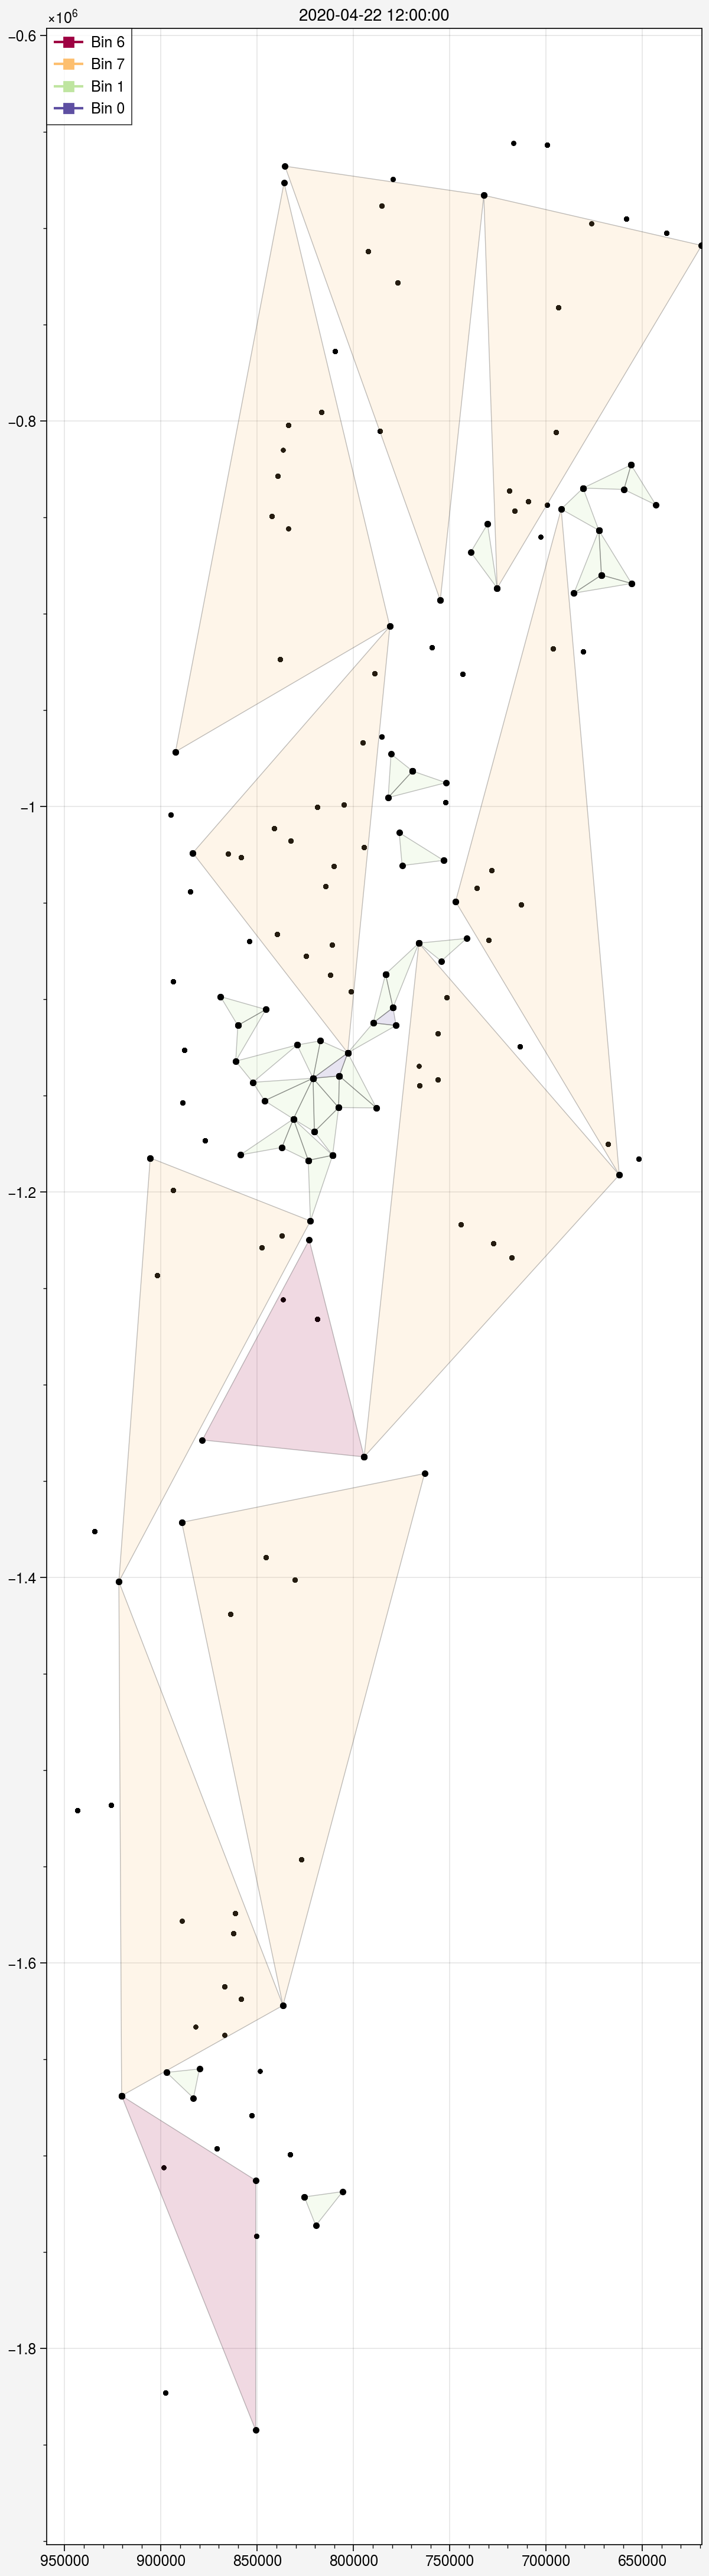

In [203]:
fig, ax = pplt.subplots(width=6, aspect=1, ncols=1)
dates = ['2005-04-22 12:00:00', '2008-04-18 12:00:00', '2020-04-22 12:00:00']
date = dates[2]
df_date = all_results.loc[all_results.datetime == date]
# All points
ax.scatter(df_date.x1.values, df_date.y1.values, color='k', ms=5)
print(df_date.loc[df_date.no_overlap_sample].groupby('log_bin').count()['u1'])
bins = df_date.loc[df_date.no_overlap_sample].log_bin.unique()
colors = [c['color'] for c in pplt.Cycle('spectral', len(bins))]
h, l = [], []
for c, bin_number in zip(colors, bins):
    df_bin = df_date.loc[(df_date.log_bin == bin_number) & df_date.no_overlap_sample]
    polygons_init = []
    for row, data in df_bin.iterrows():
        polygons_init.append(Polygon([Point(x, y) for x, y in zip([data.x1, data.x2, data.x3],
                                                    [data.y1, data.y2, data.y3])]))
    for p in polygons_init:
        ax.plot(*p.exterior.xy, color='k', lw=0.5, marker='', alpha=0.25)
        ax.plot(*p.exterior.xy, color='k', lw=0, marker='.')
        ax.fill(*p.exterior.xy, lw=0, zorder=2, alpha=0.15, c=c)

    h.append(ax.plot([],[], marker='s', color=c))
    l.append('Bin ' + str(bin_number))
ax.legend(h, l, loc='ul', ncol=1)
ax.format(title=date)
    
#         ax.format(ylim=(-1.7e6, -1.45e6), xlim=(0.76e6, 0.96e6))
#     axs[0].format(title='Unique floes', xlabel='X (m)', ylabel = 'Y (m)')
#     axs[1].format(title='Nonoverlapping polygons')

In [185]:
bin_counts

{0: 137,
 1: 500,
 2: 500,
 3: 500,
 4: 500,
 5: 500,
 6: 500,
 7: 283,
 8: 124,
 9: 25,
 10: 6}

In [186]:
all_results.loc[all_results.no_overlap_sample, ['log_bin', 'polygon_area', 'L']].groupby('log_bin').mean()

,polygon_area,L
log_bin,,
0,77.330809,8.740283
1,159.348330,12.558267
2,329.183049,18.041590
3,682.025105,25.955957
4,1462.296850,38.014138
5,3029.010442,54.679016
6,6256.871065,78.686197
7,12458.711221,110.968782
8,26539.634220,161.846656


In [190]:
def mean_accel(xcomp, ucomp, area, sign):
    """xcomp and ucomp input should be an N x 3 array. Different gradients will need
    different combinations of x, y, u, and v. In particular:
        dudx = accel(Y, U, A, 1)
        dudy = accel(X, U, A, -1)
        dvdx = accel(Y, V, A, 1)
        dvdy = accel(X, V, A, -1)
    xcomp should be in polar stereographic components.    
    """
    nr, nc = xcomp.shape
    total = np.zeros(nr)
    for idx in range(nc):
        idx1 = (idx + 1) % nc
        total += (ucomp[:, idx1] + ucomp[:, idx])*(xcomp[:, idx1] - xcomp[:, idx])
    return 1/(2*area) * total * sign

def polygon_area_uncertainty(X, Y, position_uncertainty):
    """Compute the area uncertainty following Dierking et al. 2020"""
    N = X.shape[1]
    S = 0
    for i in range(N):
        # the modulus here makes the calculation wrap around to the beginning
        # could adjust the other codes to do this too
        S += (X[:, (i+1) % N] - X[:, (i-1) % N])**2 +  (Y[:, (i+1) % N] - Y[:, (i-1) % N])**2
    return np.sqrt(0.25*position_uncertainty**2*S)

def gradvel_uncertainty(X, Y, U, V, A, position_uncertainty, time_delta, vel_var='u', x_var='x'):
    """Equation 19 from Dierking et al. 2020 assuming uncertainty in position is same in both x and y.
    Also assuming that there is no uncertainty in time. Default returns standard deviation
    uncertainty for dudx.
    """
    sigma_A = polygon_area_uncertainty(X, Y, position_uncertainty)
    sigma_X = position_uncertainty
    
    # velocity uncertainty
    if vel_var=='u':
        u = U.copy()
    else:
        u = V.copy()
    if x_var == 'x':
        # If you want dudx, integrate over Y
        x = Y.copy()
    else:
        x = X.copy()
    
    sigma_U = 2*sigma_X**2/time_delta**2
    
    
    N = X.shape[1]
    S1, S2, S3 = 0, 0, 0
    for i in range(N):
        # the modulus here makes the calculation wrap around to the beginning
        # could adjust the other codes to do this too
        S1 += (u[:, (i+1) % N] + u[:, (i-1) % N])**2 * (x[:, (i+1) % N] - x[:, (i-1) % N])**2
        S2 += (x[:, (i+1) % N] - x[:, (i-1) % N])**2
        S3 += (u[:, (i+1) % N] + u[:, (i-1) % N])**2
        
    var_ux = sigma_A**2/(4*A**4)*S1 + \
             sigma_U**2/(4*A**2)*S2 + \
             sigma_X**2/(4*A**2)*S3       
    
    return np.sqrt(var_ux)

# calculate deformation
xcoords = np.array([all_results['x1'], all_results['x2'], all_results['x3']]).T
ycoords = np.array([all_results['y1'], all_results['y2'], all_results['y3']]).T
ucoords = np.array([all_results['u1'], all_results['u2'], all_results['u3']]).T
vcoords = np.array([all_results['v1'], all_results['v2'], all_results['v3']]).T

area = all_results['polygon_area'].values*1e6 # convert back to meters. 

dudx = mean_accel(ycoords, ucoords, area, 1)
dudy = mean_accel(xcoords, ucoords, area, -1)
dvdx = mean_accel(ycoords, vcoords, area, 1)
dvdy = mean_accel(xcoords, vcoords, area, -1)

# from Lopez-Acosta et al. 2019
position_uncertainty = 255
time_delta = 24*60*60

sigma_A = polygon_area_uncertainty(xcoords, ycoords, position_uncertainty)
sigma_dudx = gradvel_uncertainty(xcoords, ycoords, ucoords, vcoords, area,
                                 position_uncertainty, time_delta, vel_var='u', x_var='x')
sigma_dvdx = gradvel_uncertainty(xcoords, ycoords, ucoords, vcoords, area,
                                 position_uncertainty, time_delta, vel_var='v', x_var='x')
sigma_dudy = gradvel_uncertainty(xcoords, ycoords, ucoords, vcoords, area,
                                 position_uncertainty, time_delta, vel_var='u', x_var='y')
sigma_dvdy = gradvel_uncertainty(xcoords, ycoords, ucoords, vcoords, area,
                                 position_uncertainty, time_delta, vel_var='v', x_var='y')


all_results['divergence'] = dudx + dvdy #div
all_results['vorticity'] = dvdx - dudy #vor
all_results['pure_shear'] = dudy + dvdx #pure
all_results['normal_shear'] = dudx - dvdy #normal
all_results['maximum_shear_strain_rate'] = 0.5*np.sqrt(all_results['normal_shear']**2 + all_results['pure_shear']**2) # eii/2
all_results['total_deformation'] = np.sqrt(all_results['divergence']**2 + \
                                           2*all_results['maximum_shear_strain_rate']**2) # 2*mssr^2 = 1/2 eii^2 

In [209]:
def normal_log_likelihood(eps, L, beta):
    n = len(eps)
    data = np.log(eps*L**beta)
    mu = np.mean(data)
    sigma = np.std(data)
    normalizer = -n/2*np.log(2*np.pi*sigma**2)
    return normalizer - np.sum(data - mu)**2/(2*sigma**2)
from scipy.stats import linregress
month = 4
bs_table = []
mle_results = []
ls_results = []
strat_samp = all_results.loc[all_results.no_overlap_sample]
for repeat in range(1000):
    resamp = strat_samp.sample(len(strat_samp), replace=True, random_state=rs + repeat)

    # MLE method - could adjust the function to accept the same data
    likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
    for beta in likelihood_results.index:
        likelihood_results.loc[beta] = normal_log_likelihood(resamp['total_deformation']*(60*60*24),
                                                             resamp['L'], beta)
        
    # if the idxmax() is equal to one side or the other, then it didn't find a maximum.
    first = np.abs(likelihood_results.idxmax() - likelihood_results.values[0]) < 1e-5
    last = np.abs(likelihood_results.idxmax() - likelihood_results.values[-10]) < 1e-5
    if not (first | last):
        mle_results.append(likelihood_results.idxmax())
    del likelihood_results

    beta, a, r, p, err = linregress(np.log(resamp['L']), np.log(resamp['total_deformation']*24*60*60))
    ls_results.append(-beta)

q1_mle, q2_mle = np.quantile(np.array(mle_results), [0.025, 0.975])
q1_ls, q2_ls = np.quantile(np.array(ls_results), [0.025, 0.975])
bs_table.append([month, q1_mle, q2_mle, q1_ls, q2_ls])
    
bs_table = pd.DataFrame(bs_table, columns=['month', 'min_beta_mle', 'max_beta_mle', 'min_beta_lsq', 'max_beta_lsq']).set_index('month')
bs_table['beta_mle'] = np.nan
bs_table['beta_lsq'] = np.nan

# This sample isn't stratified the same way -- potential for difference in numbers per day compared to other method!
strat_samp = strat_samp.loc[(strat_samp['log_bin'] > 0) & (strat_samp['log_bin'] < 10)]
likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
for beta in likelihood_results.index:
    likelihood_results.loc[beta] = normal_log_likelihood(strat_samp['total_deformation']*(60*60*24),
                                                         strat_samp['L'], beta)
beta = likelihood_results.idxmax()
bs_table.loc[month, 'beta_mle'] = beta 

beta, a, r, p, err = linregress(np.log(strat_samp['L']), np.log(strat_samp['total_deformation']*24*60*60))
bs_table.loc[month, 'beta_lsq'] = -beta
bs_table.loc[month, 'a_lsq'] = a

In [210]:
bs_table

,min_beta_mle,max_beta_mle,min_beta_lsq,max_beta_lsq,beta_mle,beta_lsq,a_lsq
month,,,,,,,
6,0.403015,0.477638,0.404656,0.478246,0.427889,0.428196,-0.473988


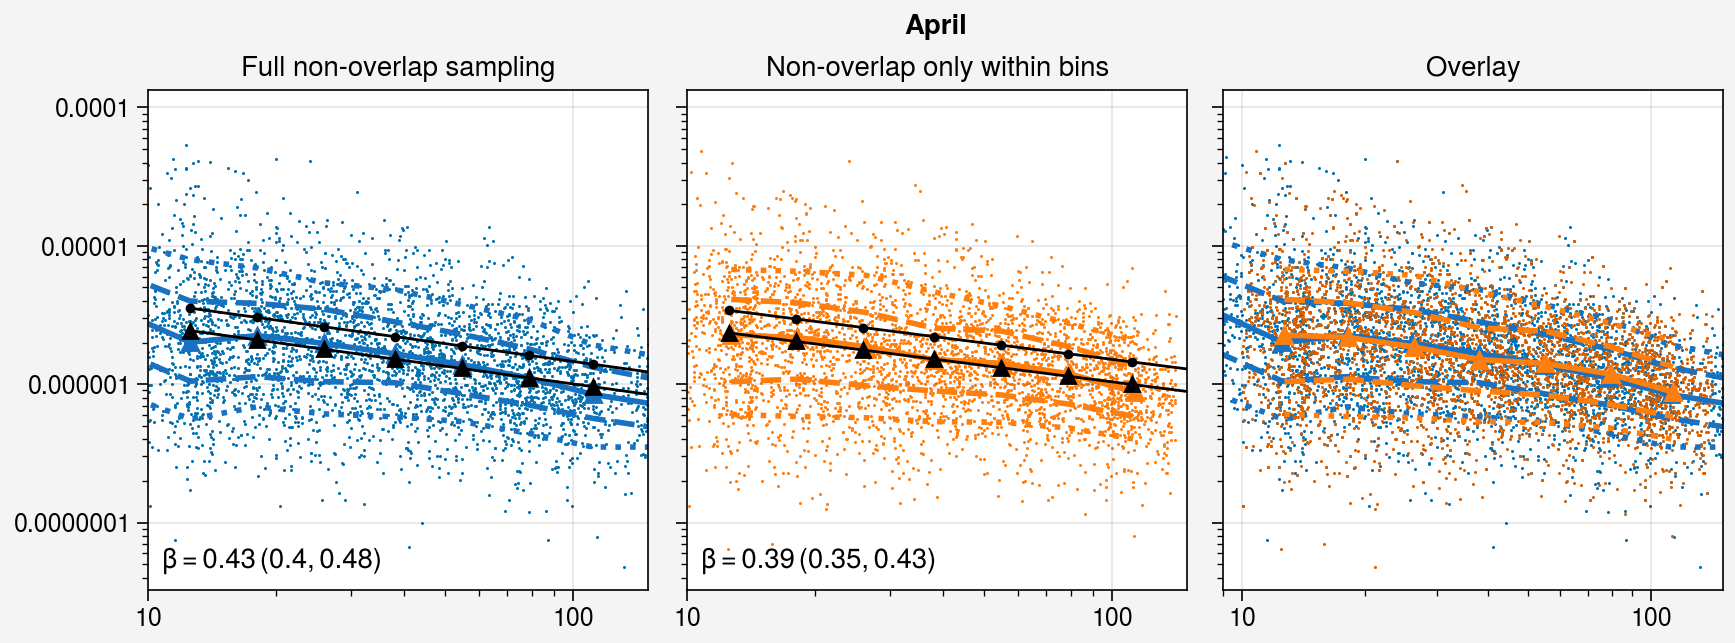

In [227]:
##### Load deformation data #######
df = pd.read_csv('../data/deformation/sampled_results.csv', index_col=0, parse_dates=['datetime'])
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

###### Calculating #######

# Stratified sample by log bin
rs = 32413
n = 500
samples = {4: [], 5: [], 6: []}
# for (month, log_bin), group in df.loc[df['unique_floes_sample'], :].groupby(['month', 'log_bin']):         
for (month, log_bin), group in df.loc[df['no_overlap_sample'], :].groupby(['month', 'log_bin']):         
    if len(group) >= n:
        if month in samples:
            # weight by the number of observations from that date
            w = 1 / group.groupby('datetime').transform(lambda x: len(x))['triangle_number']
            samples[month].append(group.sample(n, replace=False, weights=w, random_state=rs + month + log_bin))
            # weight this by the number of observations per day within each bin
    else:
        pass

for month in samples:
    samples[month] = pd.concat(samples[month], axis=0)

fig, axs = pplt.subplots(ncols=3)
axs[0].scatter(all_results.loc[all_results.no_overlap_sample, 'L'].values,
           all_results.loc[all_results.no_overlap_sample, 'total_deformation'].values, m='.', ms=1)
axs[0].format(yscale='log', xscale='log', title='Full non-overlap sampling')
axs[0].format(xlim=(10, 150))

axs[1].scatter(samples[4].loc[samples[4].no_overlap_sample, 'L'].values,
           samples[4].loc[samples[4].no_overlap_sample, 'total_deformation'].values, m='.', ms=1, color='tab:orange')
axs[1].format(yscale='log', xscale='log', title='Non-overlap only within bins')
axs[1].format(xlim=(10, 150))
axs[2].scatter(all_results.loc[all_results.no_overlap_sample, 'L'].values,
           all_results.loc[all_results.no_overlap_sample, 'total_deformation'].values, m='.', ms=1)

axs[2].scatter(samples[4].loc[samples[4].no_overlap_sample, 'L'].values,
           samples[4].loc[samples[4].no_overlap_sample, 'total_deformation'].values, m='.', ms=1)
axs[2].format(yscale='log', xscale='log', title='Overlay')
axs[2].format(xlim=(9, 150))

df_quantiles = pd.DataFrame({q: all_results.loc[all_results.no_overlap_sample, ['log_bin', 'total_deformation']].groupby('log_bin').quantile(q).values.squeeze()
                             for q in [0.1, 0.25, 0.5, .75, 0.9]},
         index = all_results.loc[all_results.no_overlap_sample, ['log_bin', 'L']].groupby('log_bin').mean().values.squeeze())

for q, ls in zip([0.1, 0.25, 0.5, .75, 0.9], [':', '--', '-', '--', ':']):
    if q == 0.5:
        m = '^'
    else:
        m = ''
    axs[0].plot(df_quantiles.index, df_quantiles[q].values, color='blue8', ls=ls, lw=2, m=m)
    axs[2].plot(df_quantiles.index, df_quantiles[q].values, color='blue8', ls=ls, lw=2, m=m)

df_quantiles = pd.DataFrame({q: samples[4].loc[samples[4].no_overlap_sample, ['log_bin', 'total_deformation']].groupby('log_bin').quantile(q).values.squeeze()
                             for q in [0.1, 0.25, 0.5, .75, 0.9]},
         index = samples[4].loc[samples[4].no_overlap_sample, ['log_bin', 'L']].groupby('log_bin').mean().values.squeeze())

for q, ls in zip([0.1, 0.25, 0.5, .75, 0.9], [':', '--', '-', '--', ':']):
    if q == 0.5:
        m = '^'
    else:
        m = ''
    axs[1].plot(df_quantiles.index, df_quantiles[q].values, color='tab:orange', ls=ls, lw=2, m=m)
    axs[2].plot(df_quantiles.index, df_quantiles[q].values, color='tab:orange', ls=ls, lw=2, m=m)

# Using the newly sampled data
ax = axs[0]
beta_mle = bs_table.loc[month, 'beta_mle']
data = all_results.loc[all_results.no_overlap_sample & all_results.log_bin.between(1, 9)]
data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
scaled_eps = data['total_deformation']*data['L']**beta_mle
mu = np.mean(np.log(scaled_eps))
sigma = np.std(np.log(scaled_eps))
mean = np.exp(mu + sigma**2/2)
stdev = np.sqrt((np.exp(sigma**2)-1)*np.exp(2*mu + sigma**2))
ax.plot(data_mean['L'].values, (np.exp(mu)*data_mean['L']**(-beta_mle)).values, label='', color='k', marker='^', ms=5, lw=1, zorder=5)
ax.plot(data_mean['L'].values, (mean*data_mean['L']**(-beta_mle)).values, label='', color='k', marker='.', ms=5, lw=1, zorder=5)

min_beta = bs_table.loc[month, 'min_beta_mle']
max_beta = bs_table.loc[month, 'max_beta_mle']    
mle_result = '$\\beta={b} \, ({minb}, {maxb})$'.format(b=np.round(beta_mle, 2),
                                                          minb=np.round(min_beta, 2),
                                                          maxb=np.round(max_beta, 2))
ax.format(lltitle=mle_result)

# Prior method
ax = axs[1]
prev_results = pd.read_csv('../data/deformation/scaling_estimates.csv')
prev_results.set_index('month', inplace=True)

month = 4
beta_mle = prev_results.loc[month, 'beta_mle']
data = all_results.loc[all_results.no_overlap_sample & all_results.log_bin.between(1, 9)]
data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
scaled_eps = data['total_deformation']*data['L']**beta_mle
mu = np.mean(np.log(scaled_eps))
sigma = np.std(np.log(scaled_eps))
mean = np.exp(mu + sigma**2/2)
stdev = np.sqrt((np.exp(sigma**2)-1)*np.exp(2*mu + sigma**2))
ax.plot(data_mean['L'].values, (np.exp(mu)*data_mean['L']**(-beta_mle)).values, label='', color='k', marker='^', ms=5, lw=1, zorder=5)
ax.plot(data_mean['L'].values, (mean*data_mean['L']**(-beta_mle)).values, label='', color='k', marker='.', ms=5, lw=1, zorder=5)

min_beta = prev_results.loc[month, 'min_beta_mle']
max_beta = prev_results.loc[month, 'max_beta_mle']    
mle_result = '$\\beta={b} \, ({minb}, {maxb})$'.format(b=np.round(beta_mle, 2),
                                                          minb=np.round(min_beta, 2),
                                                          maxb=np.round(max_beta, 2))
ax.format(lltitle=mle_result)
axs.format(suptitle='April')

<a list of 1 Line2D objects>

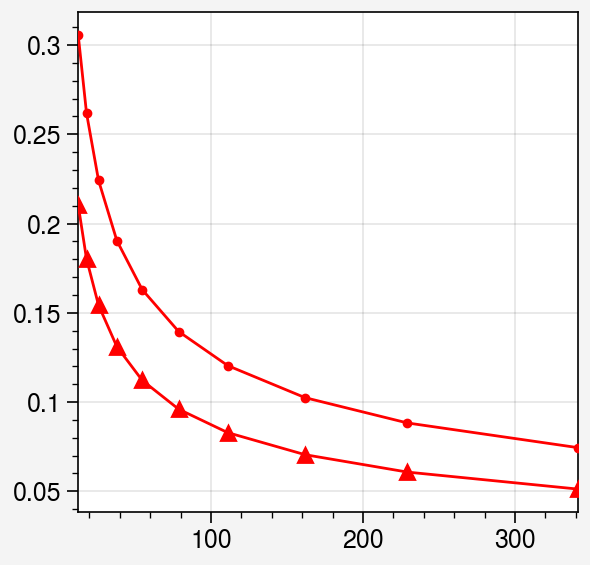

In [219]:
fig, ax = pplt.subplots()
beta_mle = bs_table.loc[month, 'beta_mle']
data = all_results.loc[all_results.no_overlap_sample & all_results.log_bin.between(1, 10)]
data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
scaled_eps = data['total_deformation']*(60*60*24)*data['L']**beta_mle
mu = np.mean(np.log(scaled_eps))
sigma = np.std(np.log(scaled_eps))
mean = np.exp(mu + sigma**2/2)
stdev = np.sqrt((np.exp(sigma**2)-1)*np.exp(2*mu + sigma**2))
ax.plot(data_mean['L'].values, (np.exp(mu)*data_mean['L']**(-beta_mle)).values, label='', color='r', marker='^', ms=5, lw=1, zorder=5)
ax.plot(data_mean['L'].values, (mean*data_mean['L']**(-beta_mle)).values, label='', color='r', marker='.', ms=5, lw=1, zorder=5)


In [17]:
ng = np.random.default_rng()
ng.choice(['1', '2', 'a'], 3, replace=False)

array(['1', '2', 'a'], dtype='<U1')

In [217]:
prev_results = pd.read_csv('../data/deformation/scaling_estimates.csv')
prev_results

,month,min_beta_mle,max_beta_mle,min_beta_lsq,max_beta_lsq,beta_mle,beta_lsq,a_lsq
0,4,0.353266,0.427889,0.351370,0.426711,0.393065,0.391720,-0.620221
1,5,0.552261,0.626884,0.550984,0.625469,0.587085,0.586496,0.306933
2,6,0.442814,0.512462,0.444911,0.512605,0.482613,0.480680,0.084463


In [ ]:




Needs for the updated methods
* Test whether I can use the powerlaw function for this analysis too
* Include floe rotation and area in the analysis




# Distribution of deformation within length scale bins
Power law distribution vs lognormal distribution. MLE estimate (Bouchat and Tremblay papers), comparison with Spreen (2017), Rampal (2019).
Clauset et al. and Bouchat and Tremblay -- use of sampling from fitted distribution and getting the p-value of the sample distribution. 

# Estimation of the scaling parameter
Bouchat and Tremblay (2020) considered the effects of uncertainty in the deformation scaling rates. They compiled a table of RGPS and buoy data used for strain rate estimation at 1 hr to 3 day time intervals. Approaches to estimating deformation at lengths scales larger than the observation resolution differ. Some authors have opted for coarse-graining, averaging the deformation estimates into larger shapes, while resampling methods evaluate new deformation estimates from subsampled data. They introduce a method for filtering out low-quality estimates of deformation.

# Effects of heterogeneity
How to determine SIC to use? 

# Granular effects
Equivalent of the Knudsen number for sea ice?

# Deformation uncertainty

The uncertainty in deformation depends on the uncertainty in velocity, position, time, and area, while the uncertainty in area depends on the position uncertainty and the shape of the triangle. We examine the uncertainty theoretically first, then look at the variation in uncertainty in the dataset.

We estimate the uncertainty in a triangle, using the formula from Dierking et al. (2020):

$$\delta_A^2 = \frac{\delta_x^2}{4}(a^2 + b^2 + c^2)$$


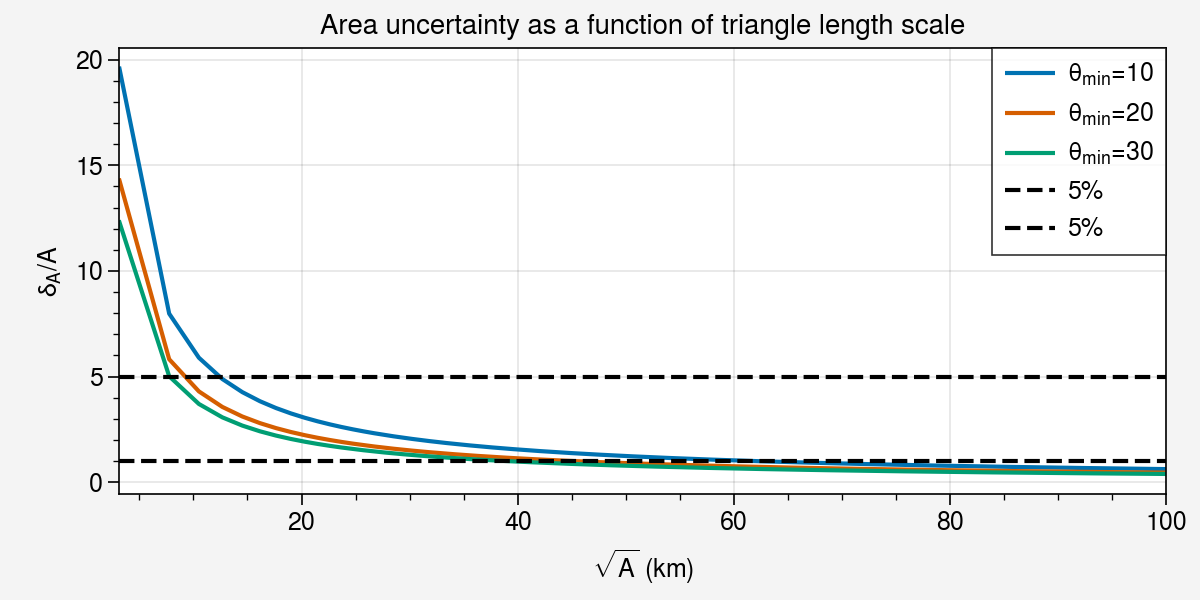

In [54]:
# Uncertainty as a function of shape for right triangles
tri_a = np.linspace(10, 100**2, 200)*1e6
def triangle_area_error(A, minimum_angle, delta_x=256):
    a = np.sqrt(2*A/np.tan(np.deg2rad(minimum_angle)))
    b = a*np.tan(np.deg2rad(minimum_angle))
    c = np.sqrt(a**2 + b**2)
    rel_a = np.sqrt(256**2/4*(a**2 + b**2 + c**2))/A
    return rel_a
    
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(np.sqrt(tri_a/1e6), triangle_area_error(tri_a, 10) * 100, label='$\\theta_{\\min}$=10')
ax.plot(np.sqrt(tri_a/1e6), triangle_area_error(tri_a, 20) * 100, label='$\\theta_{\\min}$=20')
ax.plot(np.sqrt(tri_a/1e6), triangle_area_error(tri_a, 30) * 100, label='$\\theta_{\\min}$=30')

ax.axhline(5, color='k', ls='--', label='5%')
ax.axhline(1, color='k', ls='--', label='5%')

ax.legend(ncols=1)
ax.format(ylabel='$\delta_A/A$', xlabel='$\sqrt{A}$ (km)', title='Area uncertainty as a function of triangle length scale')

In this analysis we use 20 degrees as the minimum interior angle. Next, we look at the relative uncertainty calculation from Hutchings et al. 2012.

$$\frac{\delta_\epsilon}{\epsilon} = 2\left(4 \frac{\delta_x^2}{A} + 2 \frac{\delta_x^2}{U^2T^2} + \frac{\delta_T^2}{T^2} + \frac{\delta_A^2}{A^2}\right)^{1/2}$$

The question here is what effect the minimum area has on the uncertainty as a function of mean velocity. Since the uncertainty in area is reduced as the minimum angle increases, we'll use minimum angle = 20. The uncertainty in time for the IFT product is unknown, as we have high precision when we are in the middle of an image, but the composite images have ambiguous times. So we'll look at sensitivity to time, area, and velocity.

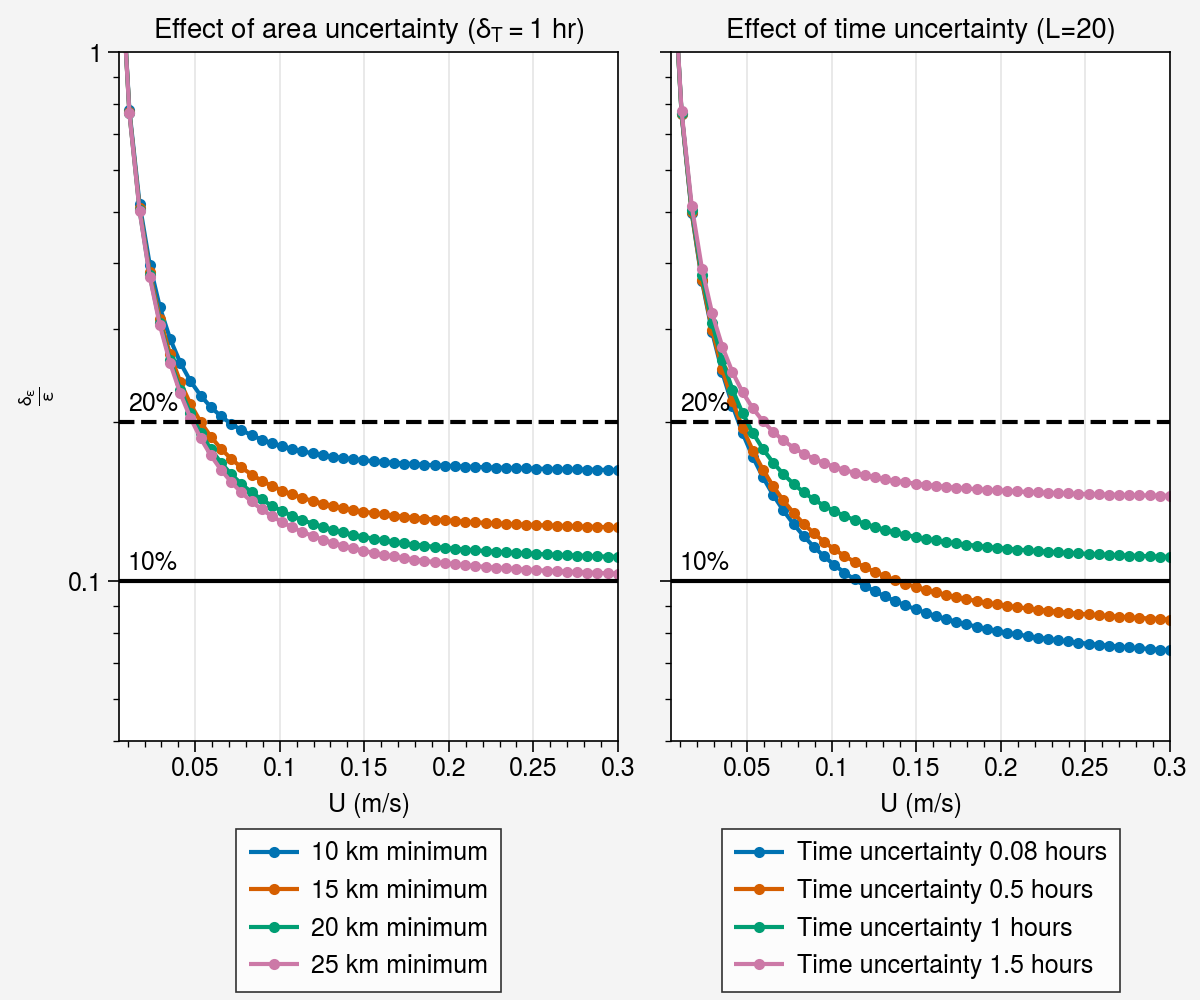

In [146]:
T = 24 # hours
delta_T = 1 # hour
delta_x = 256 # meters
U = np.linspace(0.005, 0.3) # meters per second

def rel_error_strain(A, U, T, delta_x, delta_T, delta_A):
    return 2*(4*delta_x**2 / A + 2*delta_x**2 / (U**2 * (T * 60 * 60)**2) + \
              (delta_T/T)**2 + (delta_A/A)**2)**0.5
fig, axs = pplt.subplots(width=6, height=5, ncols=2, sharex=False)
ax = axs[0]
for L in [10, 15, 20, 25]:
    A = (L * 1e3)**2
    delta_A = triangle_area_error(A, minimum_angle=20, delta_x=256)*A
    ax.plot(U, rel_error_strain(A, U, T, delta_x, delta_T, delta_A), marker='.', label='{l} km minimum'.format(l=L))
ax.axhline(0.2, ls='--', color='k')
ax.axhline(0.1, ls='-', color='k')
ax.text(0.01, 0.21, '20%')
ax.text(0.01, 0.105, '10%')

ax.format(ylabel='$\\frac{\\delta_\\epsilon}{\\epsilon}$', xlabel='U (m/s)')
ax.legend(ncols=1, loc='b')
ax.format(yscale='log', ylim=(0.05, 1), title='Effect of area uncertainty ($\delta_T = 1$ hr)')

L = 20
ax = axs[1]
for delta_T in [5/60, 0.5, 1, 1.5]:
    A = (L * 1e3)**2
    delta_A = triangle_area_error(A, minimum_angle=20, delta_x=256)*A
    ax.plot(U, rel_error_strain(A, U, T, delta_x, delta_T, delta_A), marker='.', label='Time uncertainty {t} hours'.format(t=np.round(delta_T, 2)))
ax.axhline(0.2, ls='--', color='k')
ax.axhline(0.1, ls='-', color='k')
ax.text(0.01, 0.21, '20%')
ax.text(0.01, 0.105, '10%')

ax.format(ylabel='$\\frac{\\delta_\\epsilon}{\\epsilon}$', xlabel='U (m/s)')
ax.legend(ncols=1, loc='b')
ax.format(yscale='log', ylim=(0.05, 1), title='Effect of time uncertainty (L=20)')

From this we see that the time uncertainty is a bigger factor than the triangle area. Moving to the granule data is especially important with this in mind -- we can have time errors of a few hours, I expect, if different orbits overlap, and so 

(array([ 61., 183., 319., 417., 483., 507., 488., 464., 473., 476., 348.,
        315., 294., 260., 242., 206., 199., 156., 148., 106.,  64.,  57.,
         55.,  48.,  54.,  28.,  23.,  12.,  13.,  11.,  13.,   5.,   5.,
          7.,   4.,   1.,   2.,   0.,   1.,   4.]),
 array([0.00147333, 0.00737642, 0.0132795 , 0.01918258, 0.02508567,
        0.03098875, 0.03689183, 0.04279492, 0.048698  , 0.05460108,
        0.06050417, 0.06640725, 0.07231033, 0.07821342, 0.0841165 ,
        0.09001958, 0.09592267, 0.10182575, 0.10772883, 0.11363192,
        0.119535  , 0.12543808, 0.13134117, 0.13724425, 0.14314733,
        0.14905042, 0.1549535 , 0.16085658, 0.16675967, 0.17266275,
        0.17856583, 0.18446892, 0.190372  , 0.19627508, 0.20217817,
        0.20808125, 0.21398433, 0.21988742, 0.2257905 , 0.23169358,
        0.23759667]),
 <BarContainer object of 40 artists>)

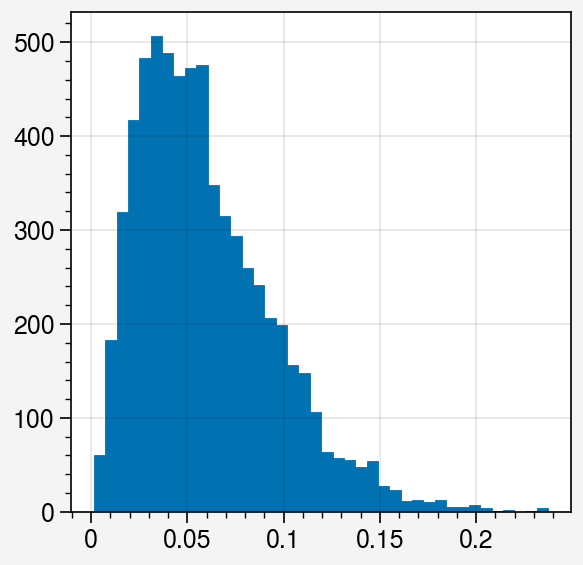

In [141]:
df = pd.read_csv('../data/deformation/sampled_results.csv')
fig, ax = pplt.subplots()
ax.hist(
    np.sqrt(
        df.loc[df.no_overlap_sample, ['u1', 'u2', 'u3']]**2).mean(axis=1), bins=40)

In [142]:
all_results['Umean'] = np.sqrt(all_results[['u1', 'u2', 'u3']]**2).mean(axis=1)

In [178]:
# all_results.loc[all_results['Umean'] > 0.05].shape
logbins = np.logspace(np.log(15), np.log(300), base=np.e, num=10)
logbins

array([ 15.        ,  20.92426191,  29.18831576,  40.71626425,
        56.79718514,  79.22927851, 110.52094496, 154.17127992,
       215.06134933, 300.        ])

In [195]:
df = pd.read_csv("../data/deformation/sampled_results.csv", parse_dates=['datetime'])
df['month'] = df.datetime.dt.month
df.loc[df.no_overlap_sample].groupby(['log_bin', 'month']).count().pivot_table(index='log_bin', columns='month', values='u1')

month,4,5,6
log_bin,,,
0,550,703,367
1,581,1000,584
2,830,1000,1000
3,859,1000,936
4,849,684,839
5,467,464,542
6,295,270,346
7,178,160,155
8,81,52,74


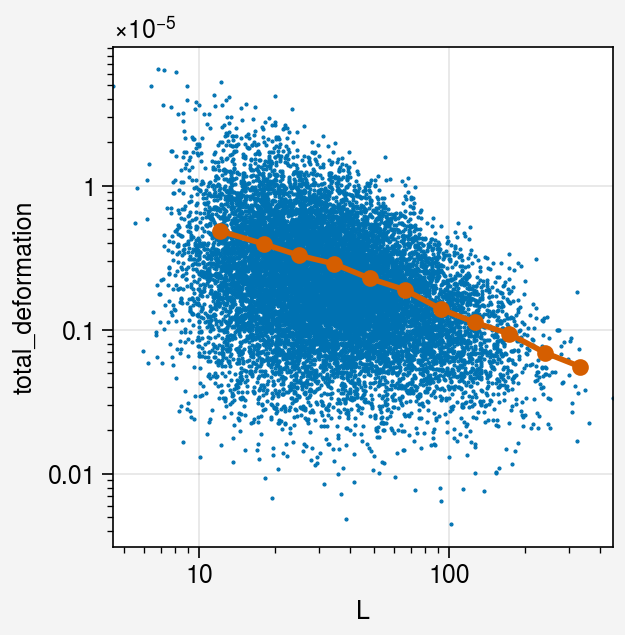

In [196]:
x = df.groupby('datetime').count()
fig, ax = pplt.subplots()
ax.plot(df.L, df.total_deformation, lw=0, m='.', ms=1)
ax.format(yscale='log', xscale='log')
ax.plot(df[['L', 'log_bin']].groupby('log_bin').mean()['L'],
        df[['log_bin', 'total_deformation']].groupby('log_bin').mean().total_deformation, lw=2, m='o', ms=5)
ax.format(xreverse=False)

In [197]:
# bootstrap estimates of the bin means, or just standard deviation?
n = df[['log_bin', 'L']].groupby('log_bin').count()['L']
L = df[['log_bin', 'L']].groupby('log_bin').mean()['L']
D = df[['log_bin', 'total_deformation']].groupby('log_bin').mean().total_deformation
D_stdev = df[['log_bin', 'total_deformation']].groupby('log_bin').std().total_deformation

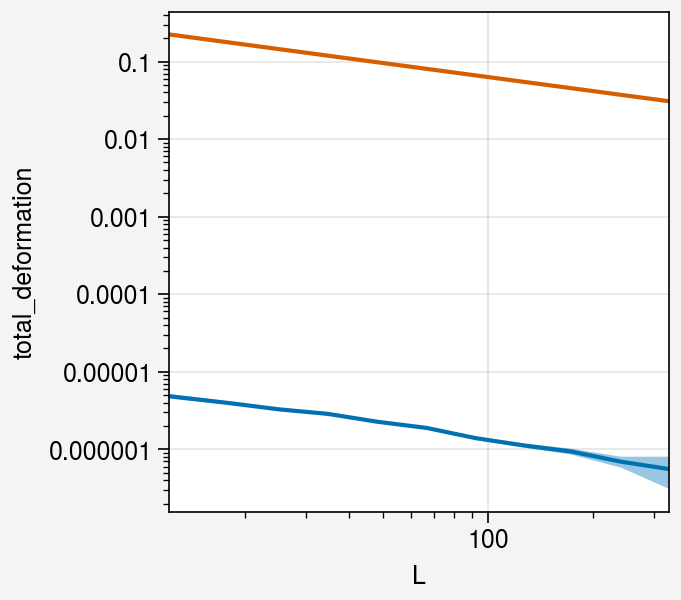

In [198]:
fig, ax = pplt.subplots()
ax.plot(L, D, shadedata=2*D_stdev/np.sqrt(n))
ax.plot(L, L**-0.6)
ax.format(yscale='log', xscale='log')

In [199]:
df.loc[df.no_overlap_sample].loc[:, ['log_bin', 'month', 'L']].groupby(
    ['log_bin', 'month']).mean().pivot_table(index='log_bin', columns='month', values='L').round(1)

month,4,5,6
log_bin,,,
0,12.2,12.0,12.3
1,18.0,18.1,18.1
2,25.1,25.0,25.1
3,34.6,34.6,34.9
4,48.0,47.8,48.1
5,66.8,66.4,66.7
6,92.4,92.5,91.9
7,126.3,126.4,126.6
8,175.4,174.0,171.6


In [158]:
for (month, log_bin), group in df.loc[df['no_overlap_sample'], :].groupby(['month', 'log_bin']):         
    print(log_bin, month, len(group))

0 4 1137
1 4 708
2 4 699
3 4 588
4 4 532
5 4 324
6 4 213
7 4 121
8 4 66
9 4 18
10 4 3
0 5 1266
1 5 993
2 5 888
3 5 628
4 5 340
5 5 259
6 5 155
7 5 107
8 5 45
9 5 21
10 5 5
0 6 818
1 6 752
2 6 841
3 6 628
4 6 455
5 6 371
6 6 201
7 6 104
8 6 55
9 6 17
10 6 3


We consider the strain rate error following Hutchings et al. 2012:
$$\frac{\delta_\epsilon}{\epsilon} = 2\left( \$$

$\Delta T = 24 h$  
Uncertainty threshold: 10%  

Case 1: When can we neglect the velocity field and its gradients?
$$ 8 \Delta T^{-2} >> 6 (u_x^2 + v_y^2) $$
With 24 hrs, we have that 
$$ \frac{8}{6 \Delta T^2} = 1.54 \times 10^{-5} \, \text{s}^{-2}$$
or 1.3 day$^{-2}$. As mentioned by Dierking et al. (and supported by the analysis here) rates of more than this are rare.

Using the term 
$$ \frac{8 \sigma^2_{coord}}{\Delta T^2 a^2} $$
for an equalateral triangle with side length $a$, 10\% for the maximum allowable uncertainty, 24 hour time step, and 255 m for the coordinate uncertainty, we get a minimum side length for detecting divergence less than or equal to 0.5 per day, 

We next turn to sea ice deformation. Deformation estimation requires a consideration of averaging area, and thus the relationship to spatial scaling for deformation differs from that of the FSD and the velocity distributions. In addition to possible effects of floe sizes, we consider the length scale defined by the square root of the area of the triangle used in the strain rate calculation. Prior work has shown that the deformation rate has a fractal-like scale dependence such that the deformation rates are linearly related to the spatial scale in log-log space: $\dot \epsilon \sim L^{-\beta}$. This is a power law form, but does not describe a statistical power law distribution.

To fit the paper better, I need to relate the deformation to the floe-scale ice motion
- smaller floes have higher perturbation velocity --> does that correspond to large deformation?
- how much of the deformation is from the large-scale flow field vs the perturbation velocities?
- if the polygon area is similar to the floe size then we'd see more granular flow effects probably.
   - Does the grain size, perhaps the area/total floe area matter?
- To what extent does the day-to-day variation in the number of polygons matter?
  - Current version has tons of overlapping polygons
  - Better to triangulate instead?

In [6]:
# Helper function for deformation
def mean_accel(xcomp, ucomp, area, sign):
    """xcomp and ucomp input should be an N x 3 array. Different gradients will need
    different combinations of x, y, u, and v. In particular:
        dudx = accel(Y, U, A, 1)
        dudy = accel(X, U, A, -1)
        dvdx = accel(Y, V, A, 1)
        dvdy = accel(X, V, A, -1)
    xcomp should be in polar stereographic components.    
    """
    nr, nc = xcomp.shape
    total = np.zeros(nr)
    for idx in range(nc):
        idx1 = (idx + 1) % nc
        total += (ucomp[:, idx1] + ucomp[:, idx])*(xcomp[:, idx1] - xcomp[:, idx])
    return 1/(2*area) * total * sign

df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

# calculate deformation
xcoords = np.array([df['x1'], df['x2'], df['x3']]).T
ycoords = np.array([df['y1'], df['y2'], df['y3']]).T
ucoords = np.array([df['u1'], df['u2'], df['u3']]).T
vcoords = np.array([df['v1'], df['v2'], df['v3']]).T

area = df['polygon_area'].values*1e6 # convert back to meters. 

dudx = mean_accel(ycoords, ucoords, area, 1)
dudy = mean_accel(xcoords, ucoords, area, -1)
dvdx = mean_accel(ycoords, vcoords, area, 1)
dvdy = mean_accel(xcoords, vcoords, area, -1)

df['divergence'] = dudx + dvdy #div = epsilon_i
df['maximum_shear_strain_rate'] = 1/2*np.sqrt((dudx - dvdy)**2 + (dudy + dvdx)**2) 
df['vorticity'] = dvdx - dudy #vor
df['pure_shear'] = dudy + dvdx #pure
df['normal_shear'] = dudx - dvdy #normal
df['total_deformation'] = np.sqrt(df['divergence']**2 + 2*df['maximum_shear_strain_rate']**2)

In [7]:
# Keeping units in meters and meters squared

# Uncertainty
dx = 255 # m -- uncertainty in the position data

# separation distance -- neglecting for now the uncertainty in each side length
df['d12'] = np.sqrt((df['x1'] - df['x2'])**2 + (df['y1'] - df['y2'])**2)
df['d13'] = np.sqrt((df['x1'] - df['x3'])**2 + (df['y1'] - df['y3'])**2)
df['d23'] = np.sqrt((df['x3'] - df['x2'])**2 + (df['y3'] - df['y2'])**2)

df['sigma_area'] = (dx**2/4*(df['d12']**2 + df['d13']**2 + df['d23']**2))**0.5

xcoords = np.array([df['x1'], df['x2'], df['x3']]).T
ycoords = np.array([df['y1'], df['y2'], df['y3']]).T

def polygon_area_uncertainty(X, Y, position_uncertainty):
    """Compute the area uncertainty following Dierking et al. 2020"""
    N = X.shape[1]
    S = 0
    for i in range(N):
        # the modulus here makes the calculation wrap around to the beginning
        # could adjust the other codes to do this too
        S += (X[:, (i+1) % N] - X[:, (i-1) % N])**2 +  (Y[:, (i+1) % N] - Y[:, (i-1) % N])**2
    return np.sqrt(0.25*position_uncertainty**2*S)

Things to figure out still:
1. What errors are there in my calculation of the uncertainty?
2. What time error should I use for the calculations?
3. How large must the triangles be to keep the uncertainty for deformation below a given threshold?

In [8]:
sa = polygon_area_uncertainty(xcoords, ycoords, dx)

In [54]:
rel_area_unc = df['area_uncertainty'] / df['polygon_area']

In [80]:
# (0.1 * sig_div)^2 = 8 * 255**2 / (delta T^2 * a)
dx = 25
alpha = 0.05
sig_div = 0.4 / (24*60*60)
delta_T = 24*60*60

a = 8 * dx**2 / (alpha * delta_T * sig_div)**2


1.388888888888889e-05

In [89]:
np.sqrt(8) * 25 / (24*0.05*0.017)

3466.2097116987616

In [15]:
# separation distance
df['d12'] = np.sqrt((df['x1'] - df['x2'])**2 + (df['y1'] - df['y2'])**2)
df['d13'] = np.sqrt((df['x1'] - df['x3'])**2 + (df['y1'] - df['y3'])**2)
df['d23'] = np.sqrt((df['x3'] - df['x2'])**2 + (df['y3'] - df['y2'])**2)

# area fraction = total floe area divided by polygon area
df['area_fraction'] = (df['area_km21'] + df['area_km22'] + df['area_km23']) / df['polygon_area']

# mean separation dist
# separation distance accounting for floe size
d12 = np.max([np.zeros(len(df)), df['d12'] - np.sqrt(df['area_km21']) - np.sqrt(df['area_km22'])], axis=0)
d13 = np.max([np.zeros(len(df)), df['d13'] - np.sqrt(df['area_km21']) - np.sqrt(df['area_km23'])], axis=0)
d23 = np.max([np.zeros(len(df)), df['d23'] - np.sqrt(df['area_km22']) - np.sqrt(df['area_km23'])], axis=0)

df['mean_separation'] = 1/3*(d12 + d13 + d23)
df['mean_separation_ratio'] = df['mean_separation']/df['L']

Analysis procedure. For each image date, I randomly shuffled the dataset, then iteratively select polygons such that each identified ice floe is only used in one polygon per bin. The minimum and maximum bins are excluded from the analysis since they have relatively few observations and cannot be guaranteed to sample the full bin range.
- min number of obs per bin?
- resampling with different initial sets?
- is the result dependent on the minimum angle? (re-run with it set to 30 degrees)
  
We want to understand the following questions
- Do we observe a similar length scale depends with these MIZ observations as we do with previous studies?
- Does the length scale relationship vary through the summer?
- Within a given range, is (a) the lognormal MLE a consistent method to estimate the scale parameter, and (b) does the lognormal distribution describe the variability within length scale bins?
- Does the 

Emphasize that we are not testing whether deformation distributions follow a power law, we are looking at whether the deformation has a power law dependence on the length scale. We are not expecting the counts to follow any particular distribution, this is not a probability distribution function.

Goodness of fit: qq plots by bin size for each month
- question of what is happening in the tails



The area uncertainty depends on perimeter

In [16]:
import powerlaw

The relative uncertainty in area decreases as the triangle size increases. With a minimum interior angle of 20, the relative error is less than 5% for triangles with length scale of 10 km or higher, and less than 1% for triangles with length scale higher than 40 km.

In [9]:
def area_uncertainty(data, dx=256):
    a2 = (data.x1 - data.x2)**2 + (data.y1 - data.y2)**2
    b2 = (data.x1 - data.x3)**2 + (data.y1 - data.y3)**2
    c2 = (data.x3 - data.x2)**2 + (data.y3 - data.y2)**2    
    return np.sqrt(dx**2/4*(a2 + b2 + c2))

## First term: Uncertainty due to position uncertainty per area


1% threshold: 102.0 km
5% threshold: 20.0 km
10% threshold: 10.0 km


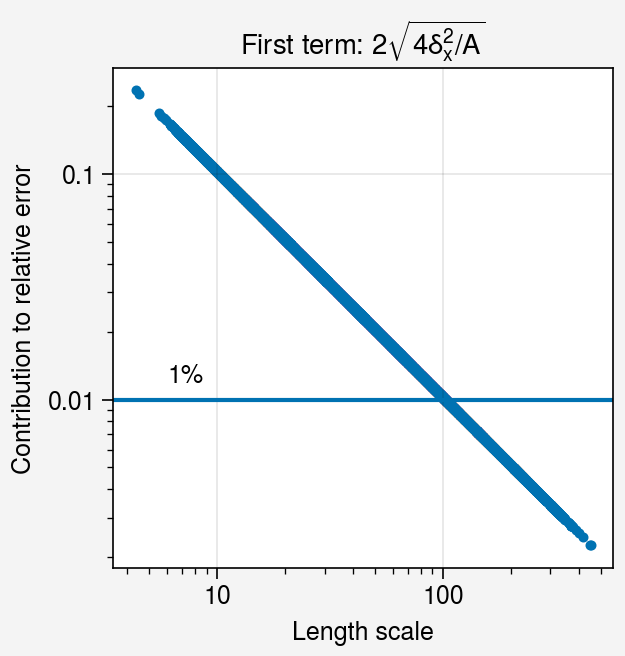

In [70]:
fig, ax = pplt.subplots()
term1 = 2*np.sqrt(4*del_x**2 / A)
ax.scatter(L, term1, marker='.')
ax.format(xscale='log', yscale='log', ylabel='Contribution to relative error', xlabel='Length scale', title='First term: 2$\sqrt{4 \delta_x^2/A}$')
ax.axhline(0.01)
ax.text(6, 0.012, '1%')
print('1% threshold:', np.round(L[term1 < 0.01].min()), 'km')
print('5% threshold:', np.round(L[term1 < 0.05].min()), 'km')
print('10% threshold:', np.round(L[term1 < 0.1].min()), 'km')

1% threshold: 102.0 km
5% threshold: 20.0 km
10% threshold: 10.0 km


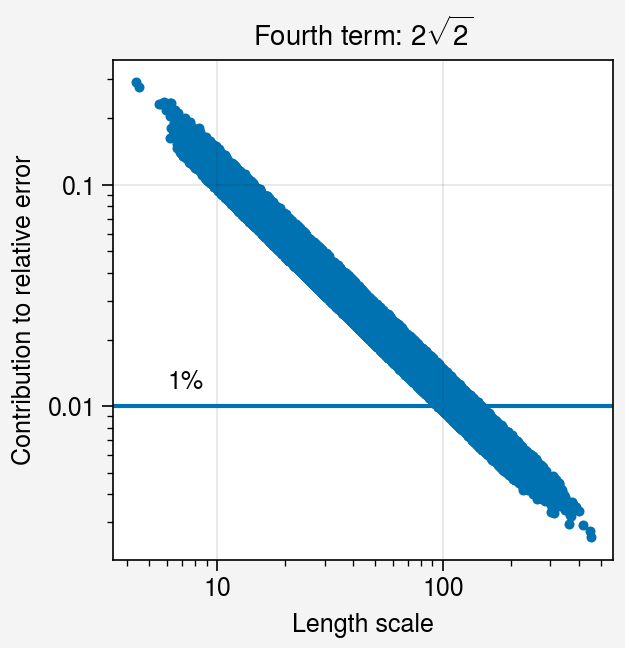

In [86]:
fig, ax = pplt.subplots()
term4 = 2*np.sqrt(2) * df['sigma_area'] / A
ax.scatter(L, term4, marker='.')
ax.format(xscale='log', yscale='log', ylabel='Contribution to relative error', xlabel='Length scale',
          title='Fourth term: 2$\sqrt{2} \frac{\delta_A}{A}$')
ax.axhline(0.01)
ax.text(6, 0.012, '1%')
print('1% threshold:', np.round(L[term1 < 0.01].min()), 'km')
print('5% threshold:', np.round(L[term1 < 0.05].min()), 'km')
print('10% threshold:', np.round(L[term1 < 0.1].min()), 'km')

1% threshold: nan km
5% threshold: 0.0 km
10% threshold: 0.0 km


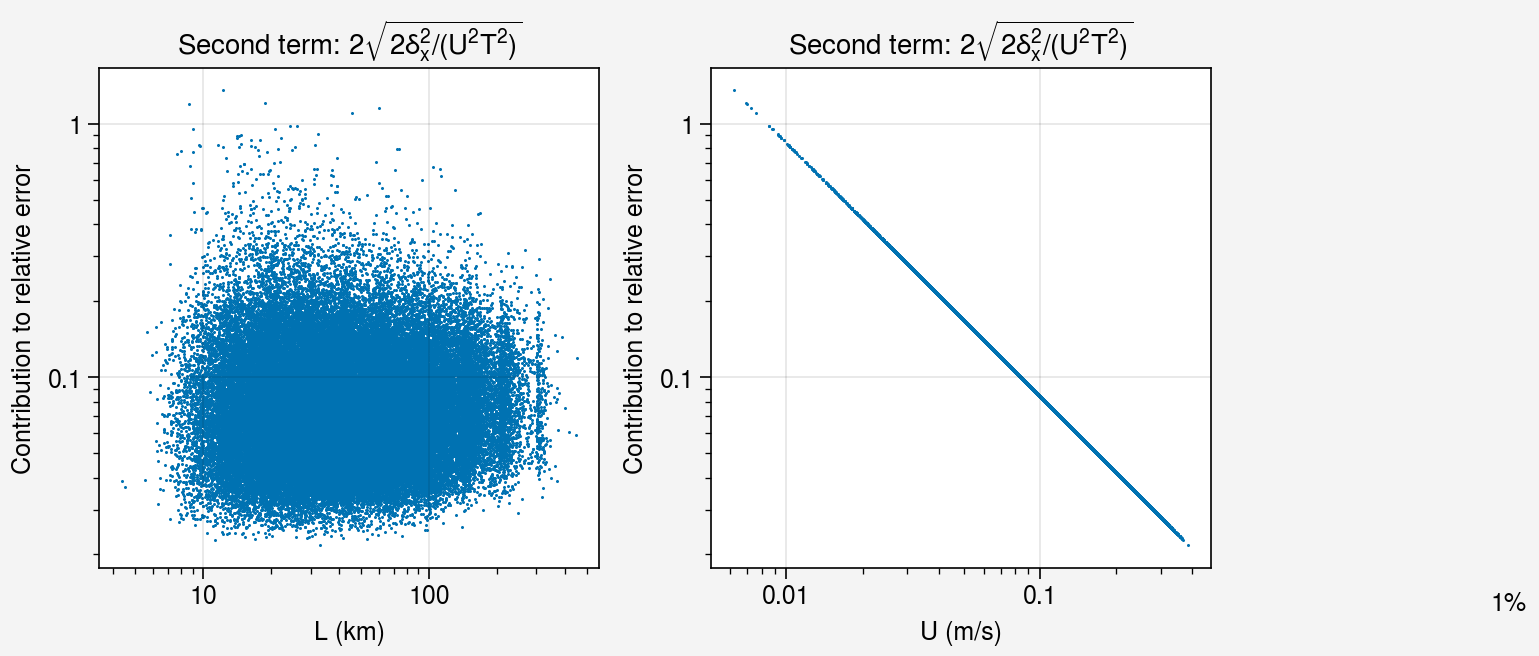

In [88]:
fig, axs = pplt.subplots(ncols=2, share=False)

# Mean U
U = ((df['u1']**2 + df['v1']**2)**0.5 + \
    (df['u2']**2 + df['v2']**2)**0.5 + \
    (df['u3']**2 + df['v3']**2)**0.5)/3

# 1-day time step
T = 24*60*60

ax = axs[0]
term2 = 2*np.sqrt(2*del_x**2 / (U**2 * T**2))
ax.scatter(L, term2, marker='.', ms=1)
ax.format(xscale='log', yscale='log', ylabel='Contribution to relative error', xlabel='L (km)',
          title='Second term: 2$\sqrt{2 \delta_x^2/(U^2T^2)}$')

ax = axs[1]
term2 = 2*np.sqrt(2*del_x**2 / (U**2 * T**2))
ax.scatter(U, term2, marker='.', ms=1)
ax.format(xscale='log', yscale='log', ylabel='Contribution to relative error', xlabel='U (m/s)',
          title='Second term: 2$\sqrt{2 \delta_x^2/(U^2T^2)}$')

# ax.axhline(0.01)
ax.text(6, 0.012, '1%')
print('1% threshold:', np.round(U[term2 < 0.01].dropna().min()), 'km')
print('5% threshold:', np.round(U[term2 < 0.05].dropna().min()), 'km')
print('10% threshold:', np.round(U[term2 < 0.1].dropna().min()), 'km')

In [82]:
2*np.sqrt(2) * 25 / (60*60)

0.019641855032959656

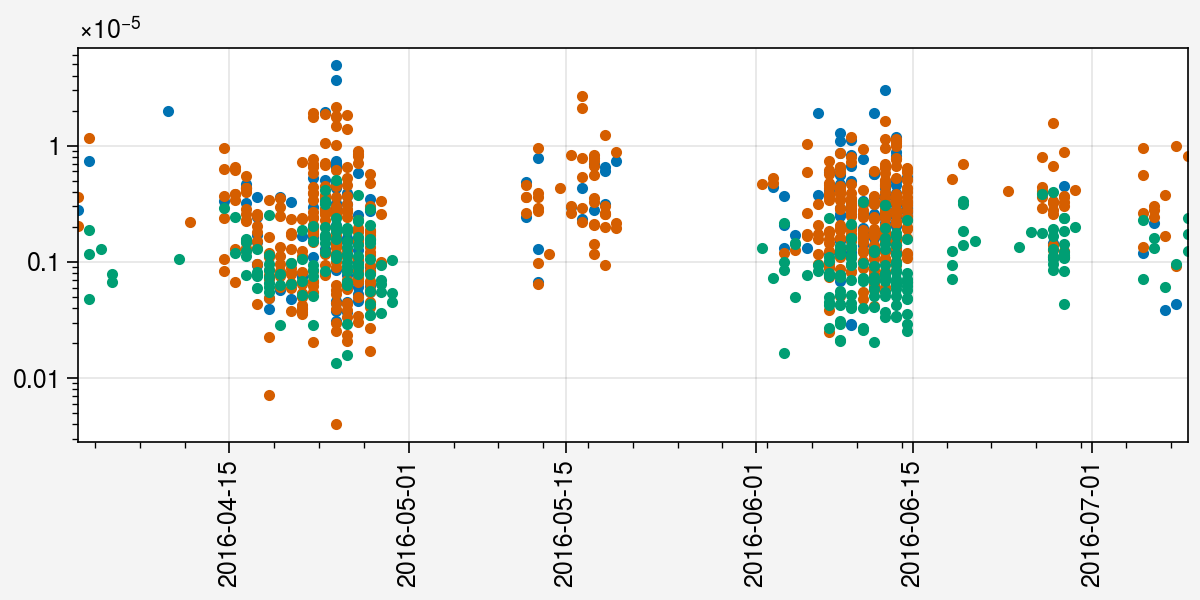

In [98]:
fig, ax = pplt.subplots(width=6, height=3)
idx = (df.log_bin == 1) & (df.datetime.dt.year == 2016)
ax.plot(df.loc[idx].datetime.values,
        df.loc[idx].total_deformation.values, marker='.',  lw=0)

idx = (df.log_bin == 3) & (df.datetime.dt.year == 2016)
ax.plot(df.loc[idx].datetime.values,
        df.loc[idx].total_deformation.values, marker='.',  lw=0)


idx = (df.log_bin == 7) & (df.datetime.dt.year == 2016)
ax.plot(df.loc[idx].datetime.values,
        df.loc[idx].total_deformation.values, marker='.',  lw=0)

ax.format(yscale='log')

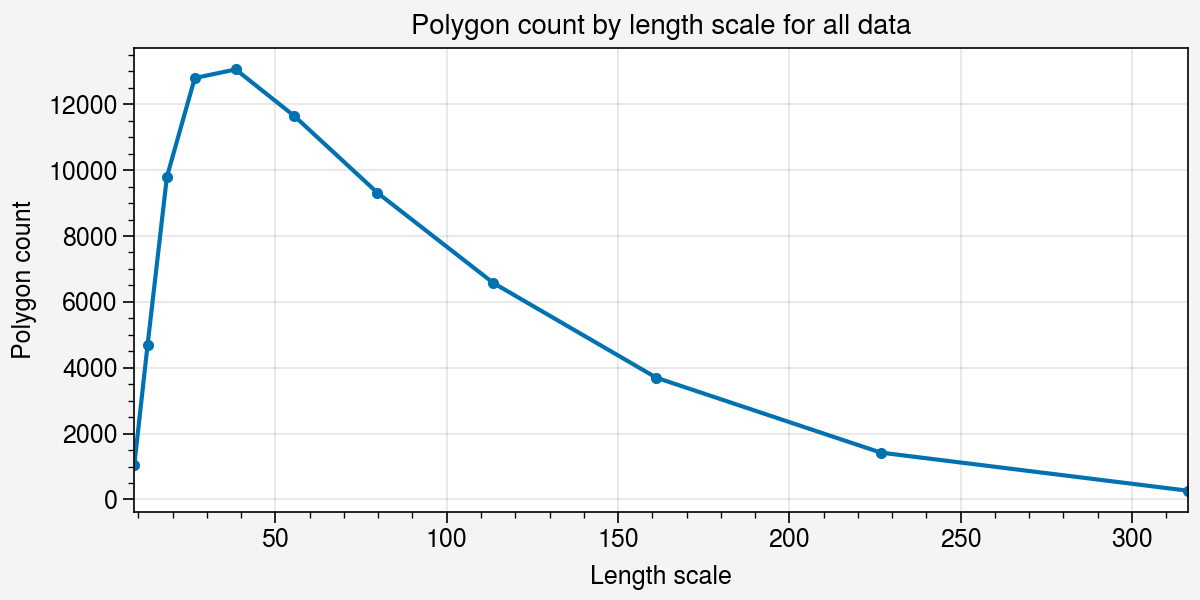

In [107]:
counts = df.groupby('log_bin').count()['datetime']
bin_mean_area = df[['log_bin', 'L']].groupby('log_bin').mean()['L']
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(bin_mean_area, counts, marker='.')
ax.format(ylabel='Polygon count', xlabel='Length scale', title='Polygon count by length scale for all data')

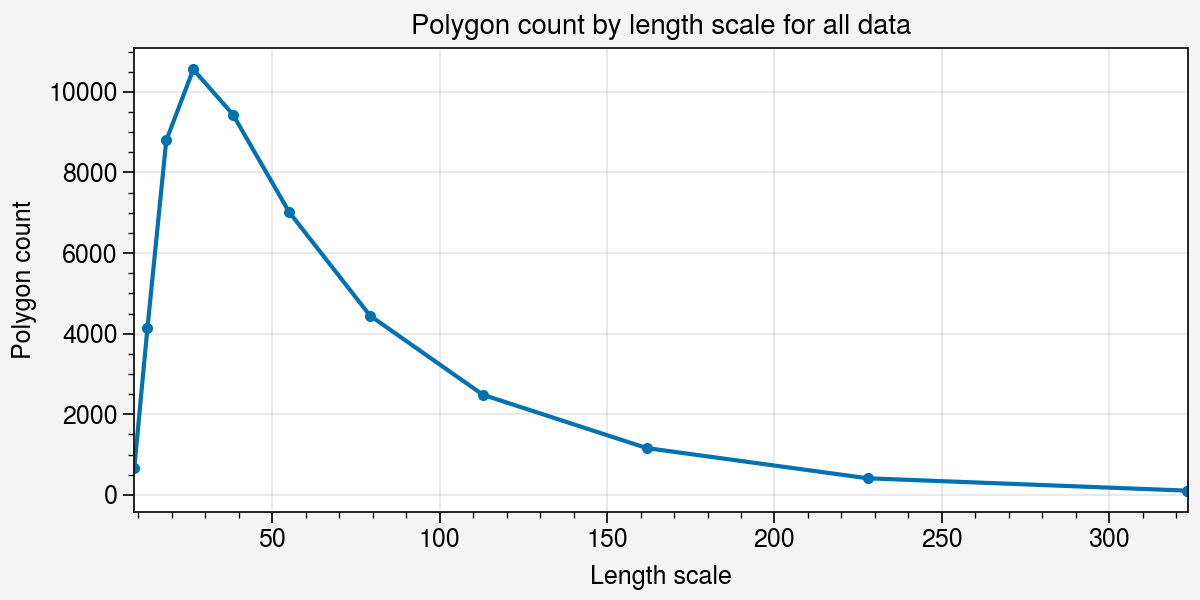

In [108]:
counts = df.loc[df.no_overlap_sample].groupby('log_bin').count()['datetime']
bin_mean_area = df.loc[df.no_overlap_sample][['log_bin', 'L']].groupby('log_bin').mean()['L']
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(bin_mean_area, counts, marker='.')
ax.format(ylabel='Polygon count', xlabel='Length scale', title='Polygon count by length scale for all data')

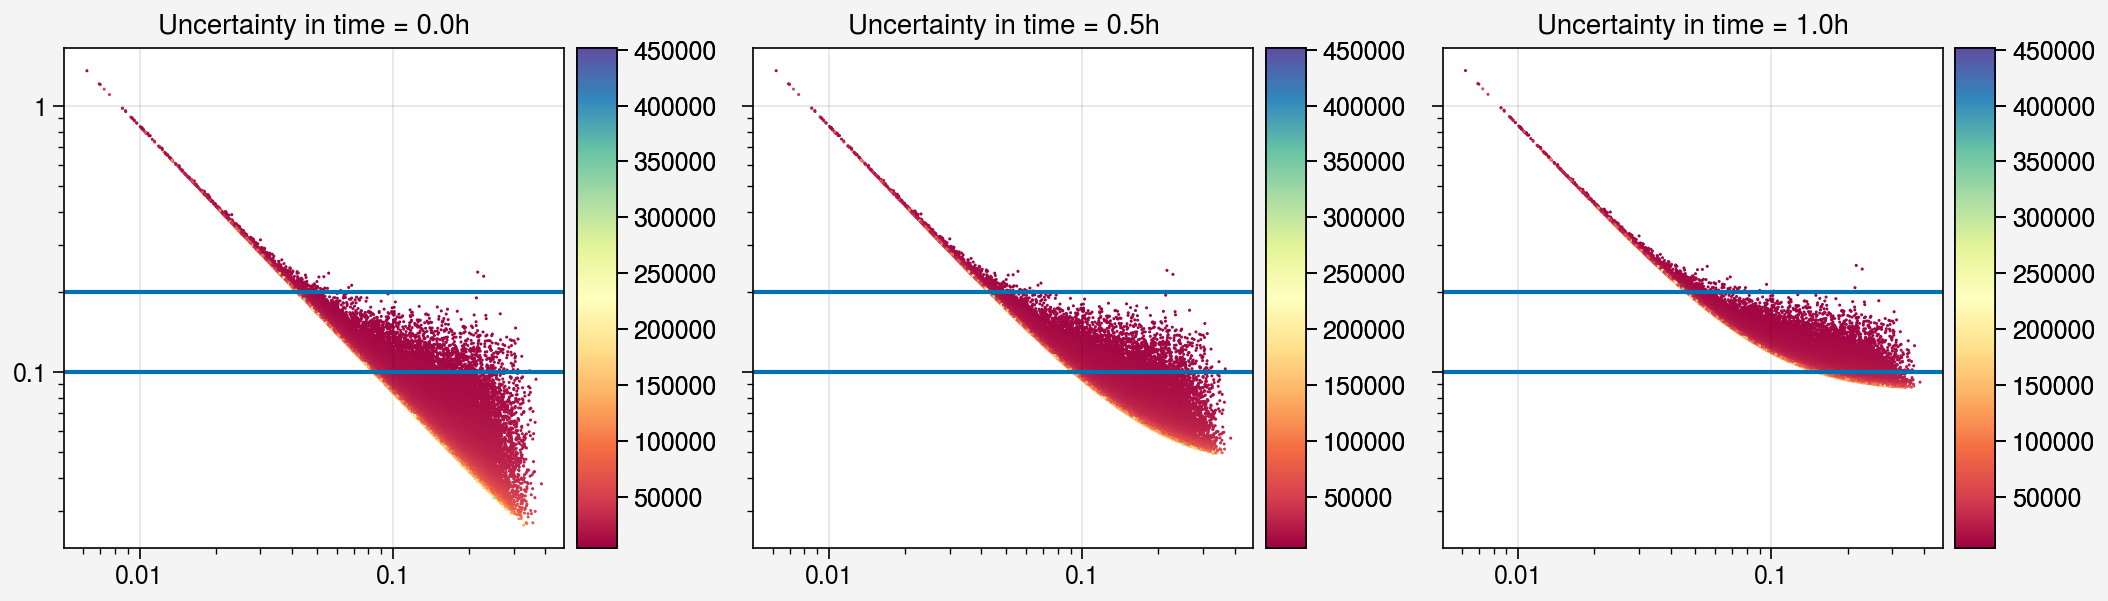

In [31]:
fig, axs = pplt.subplots(ncols=3)


# Add uncertainty calculation here
del_x = 256
T = 24*60*60 # 24 hr time step

A = df['polygon_area']*1e6 # Convert area to m2
del_A = df['sigma_area']/A

# Mean U
U = ((df['u1']**2 + df['v1']**2)**0.5 + \
    (df['u2']**2 + df['v2']**2)**0.5 + \
    (df['u3']**2 + df['v3']**2)**0.5)/3

del_T = 0*60*60 # 1 hour uncertainty in time
for ax, del_T in zip(axs, [0, 0.5*60*60, 1*60*60]):
    df['relative_error'] = 2*np.sqrt(4*del_x**2/A + \
                                    2*del_x**2/(U**2*T**2) + \
                                    del_T**2/T**2 + \
                                    del_A**2/A**2)
    
    ax.scatter(U, df['relative_error'].values, marker='.', ms=1, c=np.sqrt(A), cmap='spectral', colorbar='r')
    ax.format(xscale='log', yscale='log', title='Uncertainty in time = ' + str(del_T/(60*60)) + 'h', ylabel=')
    ax.axhline(0.2)
    ax.axhline(0.1)

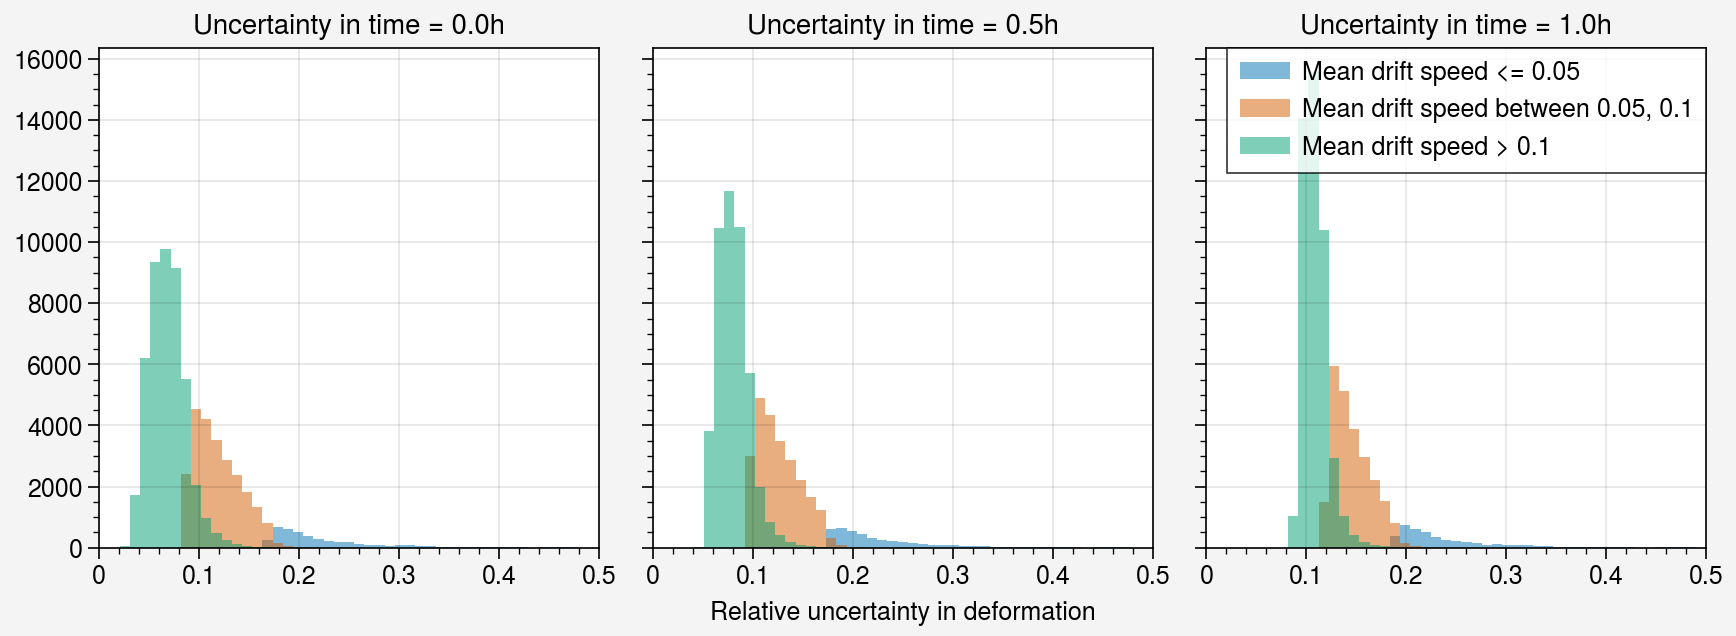

In [42]:
fig, axs = pplt.subplots(ncols=3)


# Add uncertainty calculation here
del_x = 256
T = 24*60*60 # 24 hr time step

A = df['polygon_area']*1e6 # Convert area to m2
del_A = df['sigma_area']/A

# Mean U
U = ((df['u1']**2 + df['v1']**2)**0.5 + \
    (df['u2']**2 + df['v2']**2)**0.5 + \
    (df['u3']**2 + df['v3']**2)**0.5)/3

del_T = 0*60*60 # 1 hour uncertainty in time
for ax, del_T in zip(axs, [0, 0.5*60*60, 1*60*60]):
    df['relative_error'] = 2*np.sqrt(4*del_x**2/A + \
                                    2*del_x**2/(U**2*T**2) + \
                                    del_T**2/T**2 + \
                                    del_A**2/A**2)
    ax.hist(df['relative_error'].loc[U <= 0.05].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Mean drift speed <= 0.05')
    ax.hist(df['relative_error'].loc[(U > 0.05) & (U <= 0.1)].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Mean drift speed between 0.05, 0.1')
    ax.hist(df['relative_error'].loc[U > 0.1].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Mean drift speed > 0.1')
    ax.format(title='Uncertainty in time = ' + str(del_T/(60*60)) + 'h', xlim=(0, 0.5), xlabel='Relative uncertainty in deformation')
ax.legend(ncols=1)

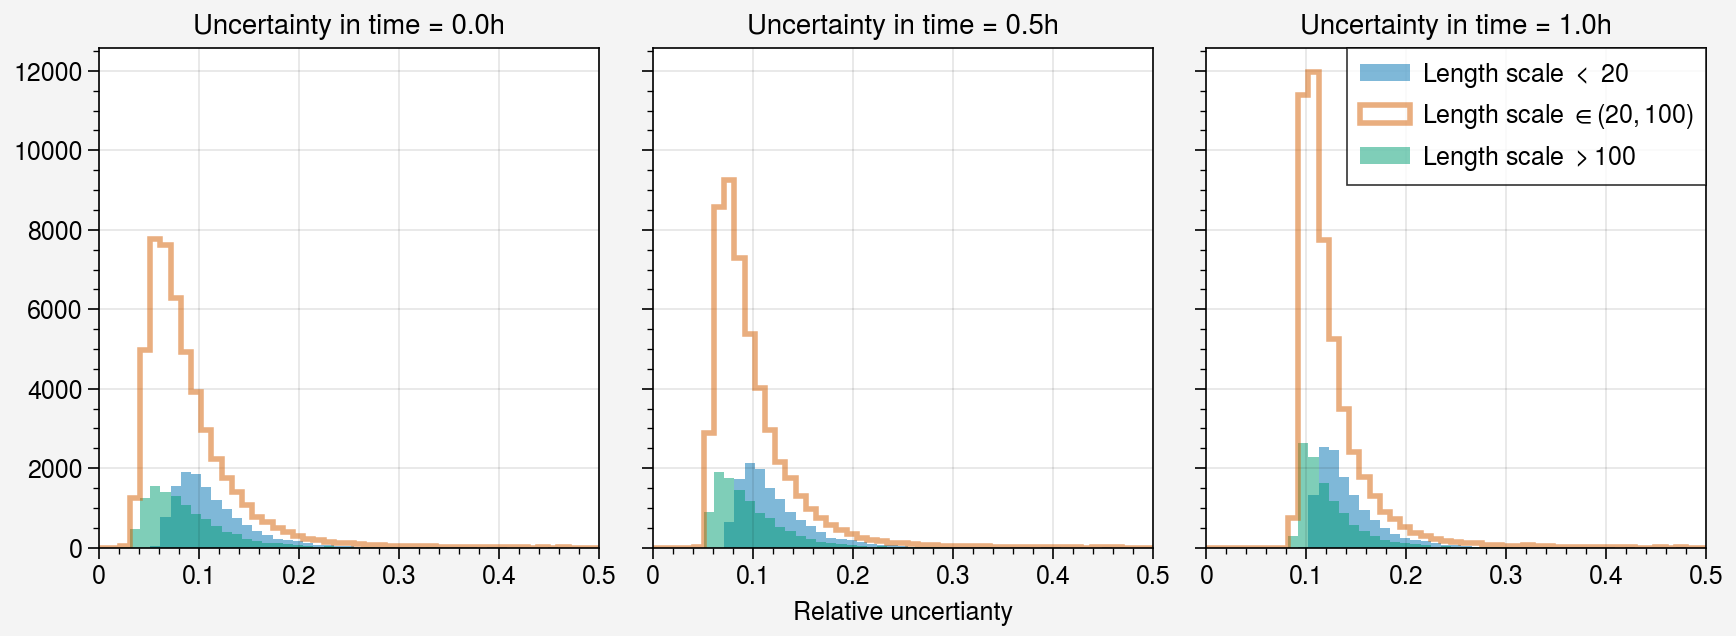

In [48]:

fig, axs = pplt.subplots(ncols=3)

# Add uncertainty calculation here
del_x = 256
T = 24*60*60 # 24 hr time step

A = df['polygon_area']*1e6 # Convert area to m2
L = df['L']
del_A = df['sigma_area']/A

# Mean U
U = ((df['u1']**2 + df['v1']**2)**0.5 + \
    (df['u2']**2 + df['v2']**2)**0.5 + \
    (df['u3']**2 + df['v3']**2)**0.5)/3

del_T = 0*60*60 # 1 hour uncertainty in time
for ax, del_T in zip(axs, [0, 0.5*60*60, 1*60*60]):
    df['relative_error'] = 2*np.sqrt(4*del_x**2/A + \
                                    2*del_x**2/(U**2*T**2) + \
                                    del_T**2/T**2 + \
                                    del_A**2/A**2)
    ax.hist(df['relative_error'].loc[L <= 20].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Length scale $<$ 20')
    ax.hist(df['relative_error'].loc[(L > 20) & (L <= 100)].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Length scale $\\in (20, 100)$',
           histtype='step', lw=2)
    ax.hist(df['relative_error'].loc[L > 100].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Length scale $>100$')
    ax.format(title='Uncertainty in time = ' + str(del_T/(60*60)) + 'h', xlim=(0, 0.5), xlabel='Relative uncertianty')
ax.legend(ncols=1)

(array([ 2743., 16047., 20198., 16330., 10431.,  5562.,  2152.,   642.,
          177.,    23.]),
 array([0.00619791, 0.04414281, 0.0820877 , 0.1200326 , 0.15797749,
        0.19592239, 0.23386728, 0.27181218, 0.30975707, 0.34770197,
        0.38564686]),
 <BarContainer object of 10 artists>)

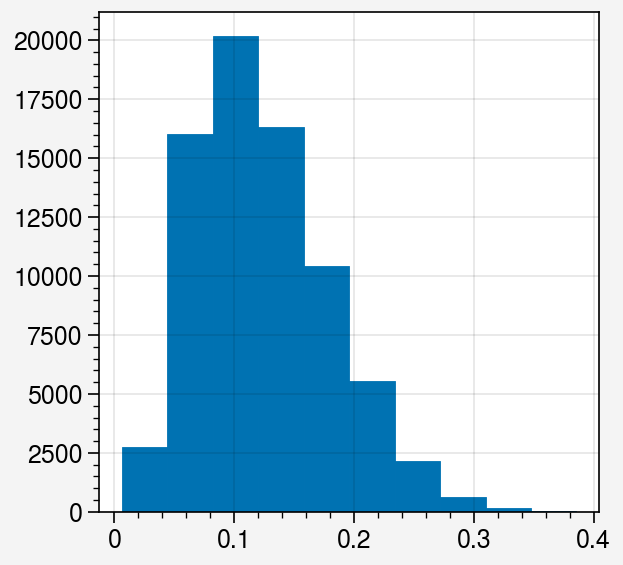

In [40]:
fig, ax = pplt.subplots()
ax.hist(U)

In [29]:
%%time
# Stratified sample by log bin
rs = 32413
n = 500
samples = {4: [], 5: [], 6: []}
for (month, log_bin), group in df.loc[df['no_overlap_sample'], :].groupby(['month', 'log_bin']):         
    if len(group) >= n:
        if month in samples:
            # weight by the number of observations from that date
            w = 1 / group.groupby('datetime').transform(lambda x: len(x))['triangle_number']
            samples[month].append(group.sample(n, replace=False, weights=w, random_state=rs + month + log_bin))
            # weight this by the number of observations per day within each bin
    else:
        pass
        
        # print(month, log_bin, len(group))
for month in samples:
    samples[month] = pd.concat(samples[month])

CPU times: user 2.12 s, sys: 14.1 ms, total: 2.13 s
Wall time: 2.13 s


(array([  738.,  2327.,  4093.,  6571.,  9206.,  9575.,  8879.,  8471.,
         8617., 15828.]),
 array([0.00160882, 0.10144794, 0.20128706, 0.30112618, 0.40096529,
        0.50080441, 0.60064353, 0.70048265, 0.80032176, 0.90016088,
        1.        ]),
 <BarContainer object of 10 artists>)

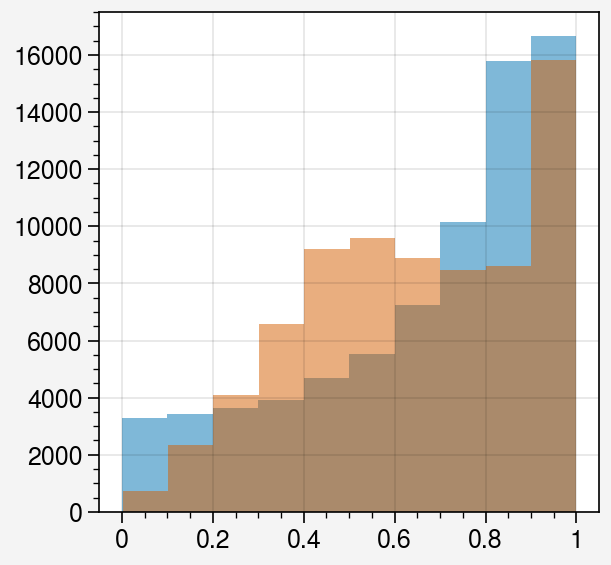

In [46]:
A = np.abs(df['divergence']) / df['total_deformation']
B = np.abs(df['maximum_shear_strain_rate']) / df['total_deformation']
fig, ax = pplt.subplots()
ax.hist(A, alpha=0.5)
ax.hist(B, alpha=0.5)

# Sensitivity of the likelihood results to the sample size
Some questions here: we're using MLE to find the slope. The new sampling method does show some differences, particularly for April. I need to figure out how things vary by length scale, and whether I'm getting the best fit with the lognormal functions. 



In [ ]:
%%time
from scipy.stats import linregress
# Build bootstrap analysis of slopes
bs_table = []
for month in samples:
    strat_samp = samples[month]
    strat_samp = strat_samp.loc[(strat_samp['log_bin'] > 0) & (strat_samp['log_bin'] < 10)]
    mle_results = []
    ls_results = []
    for repeat in range(1000):
        resamp = strat_samp.sample(len(strat_samp), replace=True, random_state=rs + repeat)

        # MLE method - could adjust the function to accept the same data
        likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
        for beta in likelihood_results.index:
            likelihood_results.loc[beta] = normal_log_likelihood(resamp['total_deformation']*(60*60*24),
                                                                 resamp['L'], beta)
        # if the idxmax() is equal to one side or the other, then it didn't find a maximum.
        first = np.abs(likelihood_results.idxmax() - likelihood_results.values[0]) < 1e-5
        last = np.abs(likelihood_results.idxmax() - likelihood_results.values[-10]) < 1e-5
        if not (first | last):
            mle_results.append(likelihood_results.idxmax())
        del likelihood_results

        beta, a, r, p, err = linregress(np.log(resamp['L']), np.log(resamp['total_deformation']*24*60*60))
        ls_results.append(-beta)
    
    q1_mle, q2_mle = np.quantile(np.array(mle_results), [0.025, 0.975])
    q1_ls, q2_ls = np.quantile(np.array(ls_results), [0.025, 0.975])
    bs_table.append([month, q1_mle, q2_mle, q1_ls, q2_ls])
    
bs_table = pd.DataFrame(bs_table, columns=['month', 'min_beta_mle', 'max_beta_mle', 'min_beta_lsq', 'max_beta_lsq']).set_index('month')
bs_table['beta_mle'] = np.nan
bs_table['beta_lsq'] = np.nan

In [37]:
for month in samples:
    strat_samp = samples[month]
    strat_samp = strat_samp.loc[(strat_samp['log_bin'] > 0) & (strat_samp['log_bin'] < 10)]
    likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
    for beta in likelihood_results.index:
        likelihood_results.loc[beta] = normal_log_likelihood(strat_samp['total_deformation']*(60*60*24),
                                                             strat_samp['L'], beta)
    beta = likelihood_results.idxmax()
    bs_table.loc[month, 'beta_mle'] = beta

    data_mean = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
    data_std = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
    n = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
    if len(data_mean) > 5:
        beta, a, r, p, err = linregress(np.log(strat_samp['L']), np.log(strat_samp['total_deformation']*24*60*60))

        bs_table.loc[month, 'beta_lsq'] = -beta
        bs_table.loc[month, 'a_lsq'] = a

# Standard approach
The typical approach, used by e.g. Hutchings et al. 2024, involves calculating a mean deformation within length scale bins. 

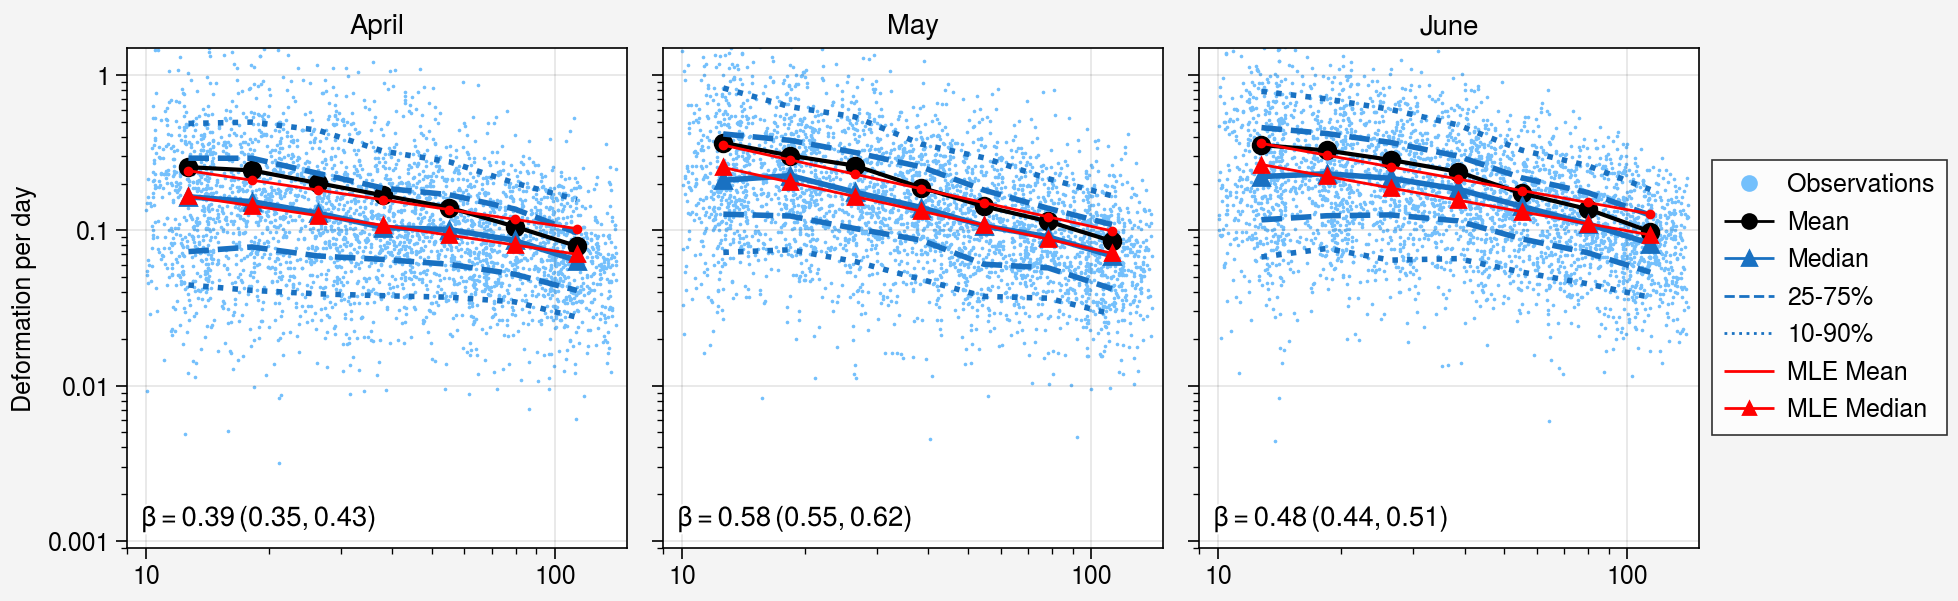

In [41]:
from scipy.stats import linregress
bs_table['reg_est'] = np.nan
fig, axs = pplt.subplots(ncols=3)
for ax, month, monthname in zip(axs, range(4, 7), ['April', 'May', 'June']):
    strat_samp = samples[month]
    strat_samp['log_total_deformation'] = np.log(strat_samp['total_deformation'])
    data = strat_samp.loc[(strat_samp.datetime.dt.month == month) & (strat_samp.no_overlap_sample)]
    data = data.loc[(data.log_bin > 0) & (data.log_bin < 10)]
    ax.scatter(data['L'].values, data['total_deformation'].values*24*60*60, m='.', color='blue3', ms=2, zorder=0, label='')
    data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
    ax.plot(data_mean['L'].values, data_mean['total_deformation'].values*24*60*60, marker='o', color='k')
    # data_std = data.loc[:, ['L', 'log_total_deformation', 'log_bin']].groupby('log_bin').std()
    
    n = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
    
    beta_mle = bs_table.loc[month, 'beta_mle']
    scaled_eps = data['total_deformation']*(60*60*24)*data['L']**beta_mle
    mu = np.mean(np.log(scaled_eps))
    sigma = np.std(np.log(scaled_eps))
    mean = np.exp(mu + sigma**2/2)
    ax.plot(data_mean['L'].values, (np.exp(mu)*data_mean['L']**(-beta_mle)).values, label='', color='r', marker='^', ms=5, lw=1, zorder=5)
    ax.plot(data_mean['L'].values, (mean*data_mean['L']**(-beta_mle)).values, label='', color='r', marker='.', ms=5, lw=1, zorder=5)
  
    min_beta = bs_table.loc[month, 'min_beta_mle']
    max_beta = bs_table.loc[month, 'max_beta_mle']    
    mle_result = '$\\beta={b} \, ({minb}, {maxb})$'.format(b=np.round(beta_mle, 2),
                                                              minb=np.round(min_beta, 2),
                                                              maxb=np.round(max_beta, 2))
    # get 95% confidence interval using standard error and t distribution
    # # tinv = lambda p, df: abs(t.ppf(p/2, df))
    # # ts = tinv(0.01, len(data_mean) - 2)

    # lr_result = '$\\beta={s:.2f} \, ({lb:.2f}, {ub:.2f})$'.format(s=-beta,
    #                                           lb=-(beta + ts*err),
    #                                           ub=-(beta - ts*err))
    beta_lsq = bs_table.loc[month, 'beta_lsq']
    min_beta = bs_table.loc[month, 'min_beta_lsq']
    max_beta = bs_table.loc[month, 'max_beta_lsq']   
    lr_result = '$\\beta={b:.2f} \, ({minb:.2f}, {maxb:.2f})$'.format(b=np.round(beta_lsq, 2),
                                                                      minb=np.round(min_beta, 2),
                                                                      maxb=np.round(max_beta, 2))
    #                                           lb=-(beta + ts*err),
    #                                           ub=-(beta - ts*err))

    df_quantiles = pd.DataFrame({q: strat_samp[['log_bin', 'total_deformation']].groupby('log_bin').quantile(q).values.squeeze()
                                 for q in [0.1, 0.25, 0.5, .75, 0.9]},
             index = strat_samp[['log_bin', 'L']].groupby('log_bin').mean().values.squeeze())

    for q, ls in zip([0.1, 0.25, 0.5, .75, 0.9], [':', '--', '-', '--', ':']):
        if q == 0.5:
            m = '^'
        else:
            m = ''
        ax.plot(df_quantiles.index, df_quantiles[q].values*24*60*60, color='blue8', ls=ls, lw=2, m=m)
    # ax.format(lltitle='MLE: ' + mle_result + '\n' + 'LSQ: ' + lr_result, xreverse=False)
    ax.format(lltitle=mle_result)
    ax.format(yscale='log', xscale='log', ylim=(0.9e-3, 1.5), ylabel='Deformation per day', xlim=(9, 150), title=monthname, xreverse=False)

h = [ax.plot([],[], c=c, lw=lw, m=m, ms=ms, ls=ls) for c, lw, m, ms, ls in zip(
                ['blue3', 'k', 'blue8', 'blue8', 'blue8', 'r', 'r'],
                [0, 1, 1, 1, 1, 1, 1],
                ['o', 'o', '^', '', '', '.', '^'],
                [5, 5, 5, 0, 0, 0, 4, 5],
                ['', '-', '-', '--', ':', '-', '-'])]
 

# make custom legend
ax.legend(h, ['Observations', 'Mean', 'Median', '25-75%', '10-90%', 'MLE Mean', 'MLE Median'], ncols=1,loc='r')
# fig.save('../figures/fig10_deformation_scales.png', dpi=300)

In [3]:
import pandas as pd
import powerlaw
import numpy as np

data = pd.read_csv('../data/deformation/sampled_results.csv', parse_dates = ['datetime'], index_col=0)

There are two main ways I want to talk about the the results of the distribution
- First, comparison with the lognormal fit. The assumption is that a single beta parameter describes the distribution. However, we see that this assumption results in biased estimates of the median across scales, and an assumption of constant slope for both the mean and the median. What we are seeing is that the distribution is changing in time.
- Second, I want to use the power law function to evaluate the goodness of fit of the various distributions. Can we describe the data as lognormal?

In [32]:
df = data.loc[(data.log_bin == 8) & data.no_overlap_sample]

In [33]:
fit = powerlaw.Fit(df['total_deformation'])

Calculating best minimal value for power law fit
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


SubplotGrid(nrows=1, ncols=1, length=1)

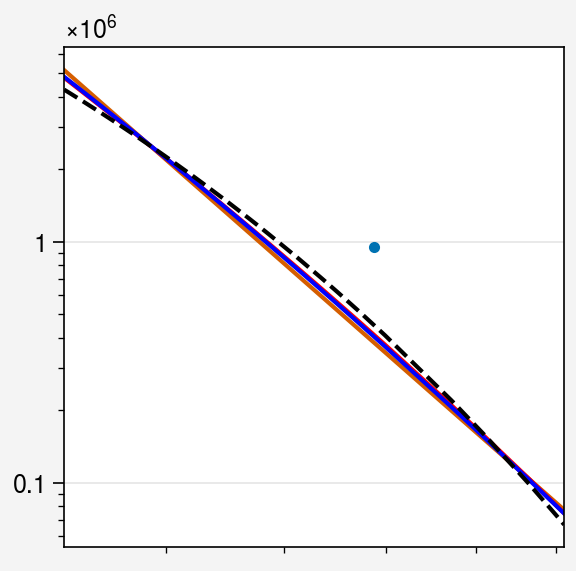

In [34]:
fig, ax = pplt.subplots()
fit.plot_pdf(ax=ax, marker='.')
fit.power_law.plot_pdf(ax=ax)
fit.truncated_power_law.plot_pdf(ax=ax, color='r')
fit.lognormal.plot_pdf(ax=ax, color='b')
fit.exponential.plot_pdf(ax=ax, color='k', ls='--')

In [35]:
print('LN vs EXP', fit.distribution_compare('lognormal', 'exponential'))
print('LN vs PL', fit.distribution_compare('lognormal', 'power_law'))
print('LN vs TPL', fit.distribution_compare('lognormal', 'truncated_power_law'))

LN vs EXP (0.21931138621035196, 0.7062301644488128)
LN vs PL (0.10019864981208393, 0.7405123016977534)
LN vs TPL (-0.060342174227288936, 0.32665634033813196)


Bin 1: The lognormal distribution proves to be a better fit than the power law or exponential, but the truncated power law outperforms the lognormal.
Bin 5: Exponential and lognormal indistinguishable, LN better than PL, TPL better than LN.

(0.5022114612962548, 0.49943296050441954, 0.7217974334120242)

Assuming that
$$ y \propto mL^{-\beta}$$
For the LSQ method, we fit a line to the log-transformed data:
$$\log y = \log m - \beta \log L$$
The resulting parameters give us the slope $\beta$ and a y-intercept $A = \log m$ in log space. To transform back into data space, we simply take the exponent of each side, so the estimated value for $m$ is $\exp(A)$.


The line for the MLE method is given by the function
$$ y = mL^{-\beta} $$
where $m = \exp(\mu + \sigma^2/2)$ is the mean of the fitted lognormal distribution with parameters $\mu$, $\sigma$.

TBD:
- Sensitivity of the MLE estimate to outliers
- Sensitivity to sample size
- Uncertainty in the LS mean (add to plot)





(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1.00000023, 1.00000276, 1.0000053 , 1.00000783, 1.00001036,
        1.00001289, 1.00001543, 1.00001796, 1.00002049, 1.00002303]),
 <BarContainer object of 9 artists>)

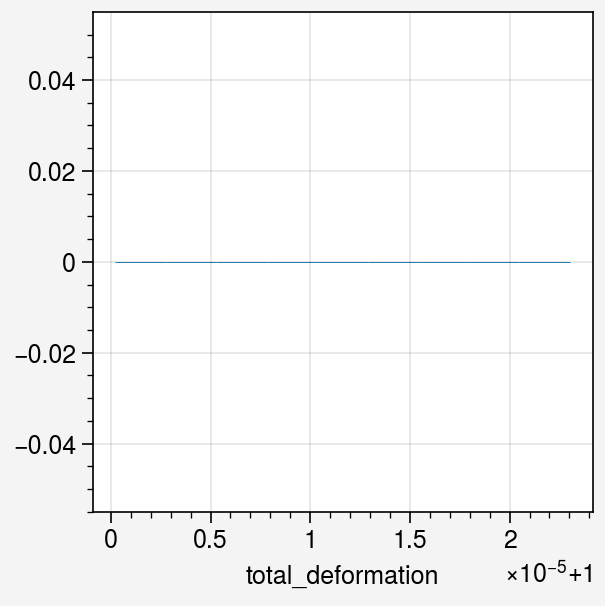

In [227]:
fig, ax = pplt.subplots()
ax.hist(strat_samp.loc[strat_samp.log_bin == 5, 'total_deformation'], bins=np.logspace(0.1e-6, 1e-5, 10))
# ax.format(xscale='log')


In [229]:
np.logspace(0.1e-6, 1e-5, 10)

array([2.71828245, 2.71828934, 2.71829622, 2.71830311, 2.71830999,
       2.71831688, 2.71832376, 2.71833065, 2.71833754, 2.71834442])

In [442]:
import statsmodels.api as sm
np.exp(np.mean(data['total_deformation']*data['L']**beta_mle))

1.000005986501369

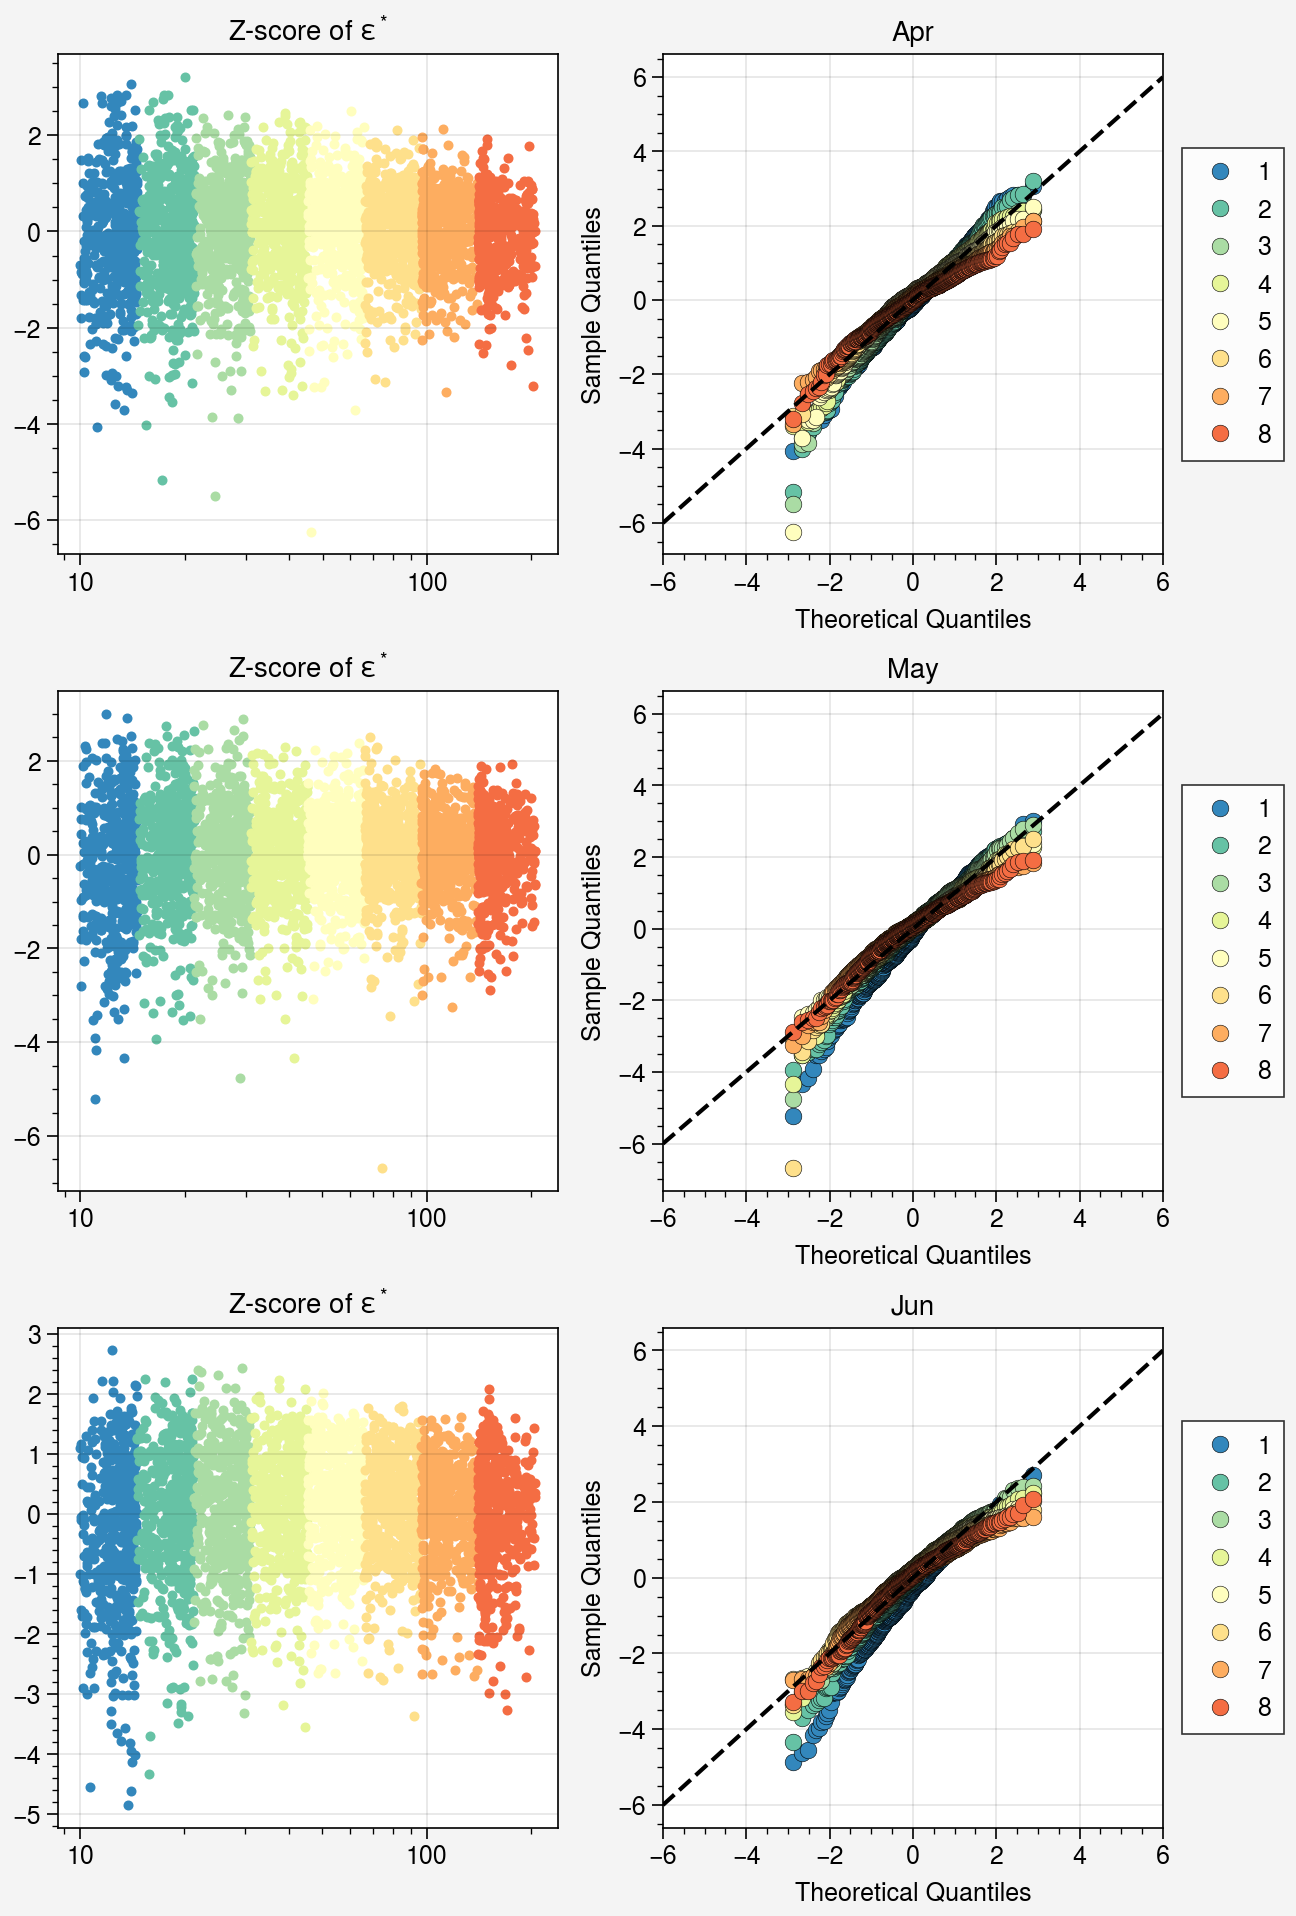

In [479]:
bincolors = {lb: color['color'] for lb, color in zip(np.arange(0, 11),
                                                pplt.Cycle('spectral_r',11))}
fig, axs = pplt.subplots(ncols=2, nrows=3, share=False)
for row, month, monthname in zip([0, 1, 2], [4, 5, 6], ['Apr', 'May', 'Jun']):
    beta_mle = bs_table.loc[month, 'beta']
    strat_samp = pd.concat(samples[month])
    data = np.log(strat_samp['total_deformation']*strat_samp['L']**beta_mle)
    data = pd.DataFrame({'Z': (data - np.mean(data))/np.std(data), 'L': strat_samp['L'], 'log_bin': strat_samp['log_bin']})
    
    axs[row, 0].format(xscale='log', title='Z-score of $\epsilon^*$')
    
    for lbin, group in data.groupby('log_bin'):
        axs[row, 0].scatter(group['L'].values, group['Z'].values, color=bincolors[lbin], marker='.')
        sm.qqplot(group['Z'], ax=axs[row, 1], **{'marker': 'o', 'markerfacecolor': bincolors[lbin], 'markeredgecolor':'k', 'markeredgewidth': 0.2, 'label': lbin})
    axs[row, 1].plot([-6, 6], [-6, 6], color='k', ls='--')
    axs[row, 1].format(title=monthname)
        # ax.hist(group['Z'], bins=np.linspace(-5, 5, 31),
        #         density=True, label='Bin {lb}: {km} km'.format(lb=lbin, km=np.round(np.mean(group['L']), 1)), histtype='step')
    axs[row, 1].legend(ncols=1, loc='r')
    

Some notes based on plotting single groups at a time:
* Small scales seem identically distributed (log bins 1 and 2). Both have a tilted qq plot showing relatively more frequent low values and less frequent high values.
* Next, 3 and 4 are closer to the lognormal distribution for the higher values, but still have relatively more frequent low Z scores
* 5-7 have more frequent high values and less frequent low values, the qq plot is skewed the opposite way
* 

0 0.08
1 0.11
2 0.01
3 0.92
4 0.65
5 0.56
6 1.06
7 0.89
8 0.59
9 0.83
10 0.52
11 1.4


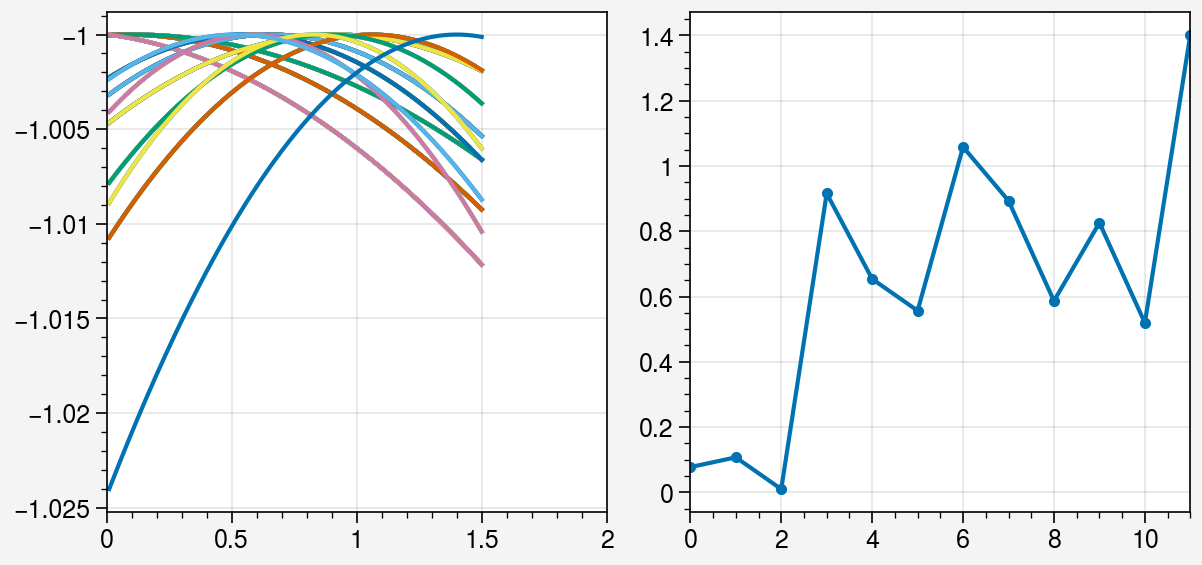

In [79]:
fig, axs = pplt.subplots(ncols=2, share=False)
likelihood_results = pd.DataFrame(np.nan, index=np.linspace(0.01, 1.5, 200), columns=np.arange(0, 11))
for binnum, data in all_results.groupby('log_bin'):
    if len(data) > 1000:
        d = data['total_deformation'].sample(1000)
        for beta in likelihood_results.index:
            likelihood_results.loc[beta, binnum] = normal_log_likelihood(d*(60*60*24),
                                                                 data['L'], beta)
        axs[0].plot(likelihood_results/np.abs(likelihood_results.max()))
        print(binnum, np.round(likelihood_results[binnum].idxmax(),2))
axs[1].plot(likelihood_results.idxmax(axis=0), marker='.')
axs[0].format(xlim=(0, 2))

# TBD
* Compare the local fit to the global fit with alternative methods of fitting a lognormal distribution. Can we rule it out? Are we getting the best mu/std estimates?

Powerlaw distribution application to the data within a length scale bin

In [95]:
import powerlaw
data = pd.concat(samples[5])

In [ ]:
fig, ax = pplt.subplots(width=4)
for log_bin in range(1, 9):
    fit = powerlaw.Fit(np.abs(data.loc[data.log_bin == log_bin, 'divergence']))
    fit.plot_ccdf(ax=ax, color='k')
    fit.lognormal.plot_ccdf(ax=ax, ls='--', color='r')
    fit.power_law.plot_ccdf(ax=ax, ls=':', color='b')

Calculating best minimal value for power law fit
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


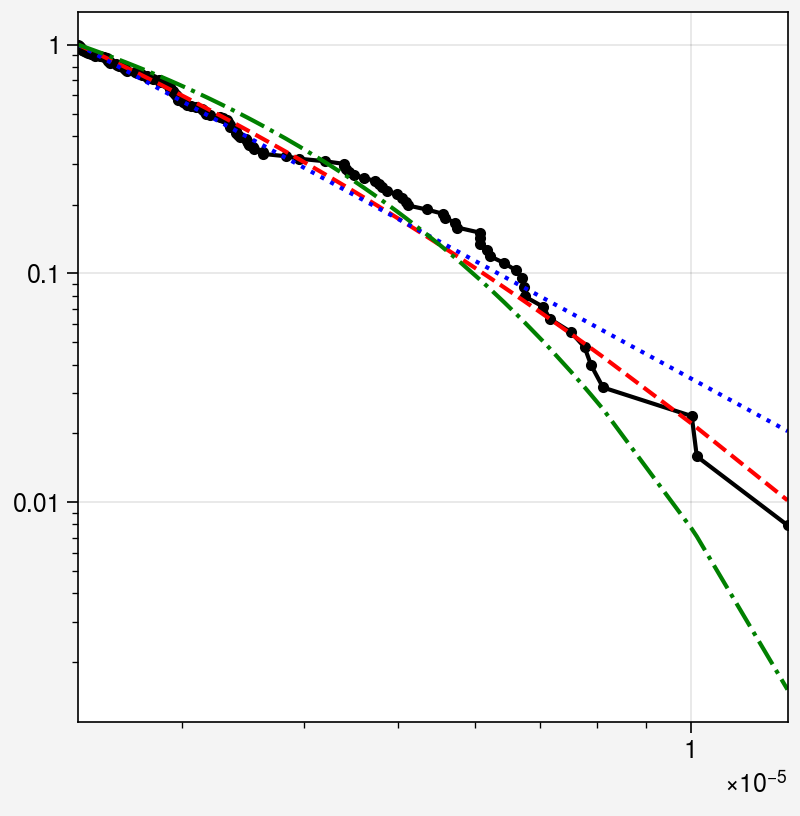

In [108]:
fig, ax = pplt.subplots(width=4)
log_bin = 3
for year in range(2003, 2004):
    d = data.loc[(data.log_bin == log_bin), 'total_deformation']
    fit = powerlaw.Fit(np.abs(d))
    fit.plot_ccdf(ax=ax, color='k', marker='.')
    fit.lognormal.plot_ccdf(ax=ax, ls='--', color='r')
    fit.power_law.plot_ccdf(ax=ax, ls=':', color='b')
    fit.exponential.plot_ccdf(ax=ax, ls='-.', color='g')
# fit.exponential.plot_ccdf(ax=ax)

In [105]:
print(fit.distribution_compare('power_law', 'truncated_power_law', nested=True))
print(fit.distribution_compare('power_law', 'lognormal', nested=True))
print(fit.distribution_compare('power_law', 'exponential', nested=True))
print(fit.distribution_compare('lognormal', 'exponential', nested=True))
print(fit.distribution_compare('lognormal', 'truncated_power_law', nested=True))

(-1.6104207038728378, 0.07270624867493292)
(-1.105953826468446, 0.1369492305833674)
(1.266354447109813, 0.11150863677036904)
(2.372308273578259, 0.029390102836980625)
(-0.5044668774043917, 0.31515841391077304)


Assuming nested distributions
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


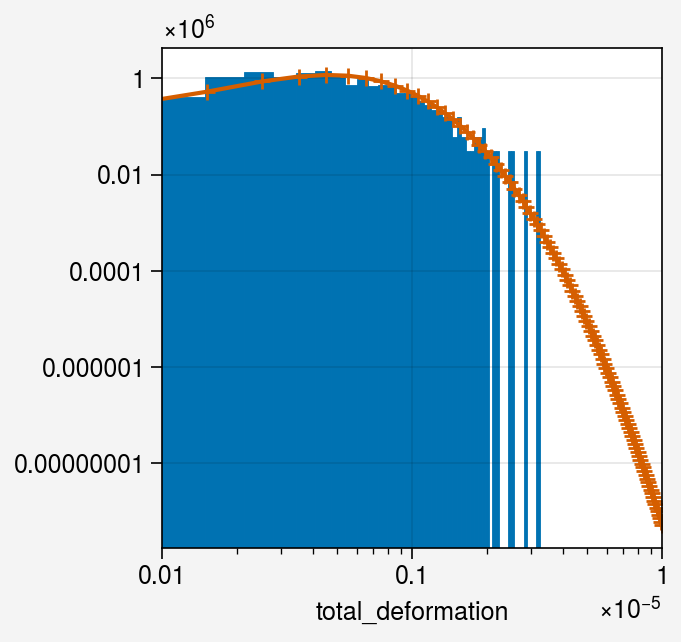

In [141]:
import scipy.stats as stats
fig, ax = pplt.subplots()
log_bin = 7
x = np.abs(data.loc[data.log_bin == log_bin, 'total_deformation'])
ax.hist(x, bins=50, density=True)
shape, location, scale = stats.lognorm.fit(x)
ax.plot(np.linspace(0.5e-7, 1e-5, 100), stats.lognorm.pdf(np.linspace(1e-8, 1e-5, 100), shape, location, scale), marker='+')
ax.format(yscale='log', xscale='log', xlim=(1e-7, 1e-5))

In [519]:
fit.lognormal.mu, fit.lognormal.sigma

(-15.567266079668826, 0.997892889227757)

-2.895422811760541e-07

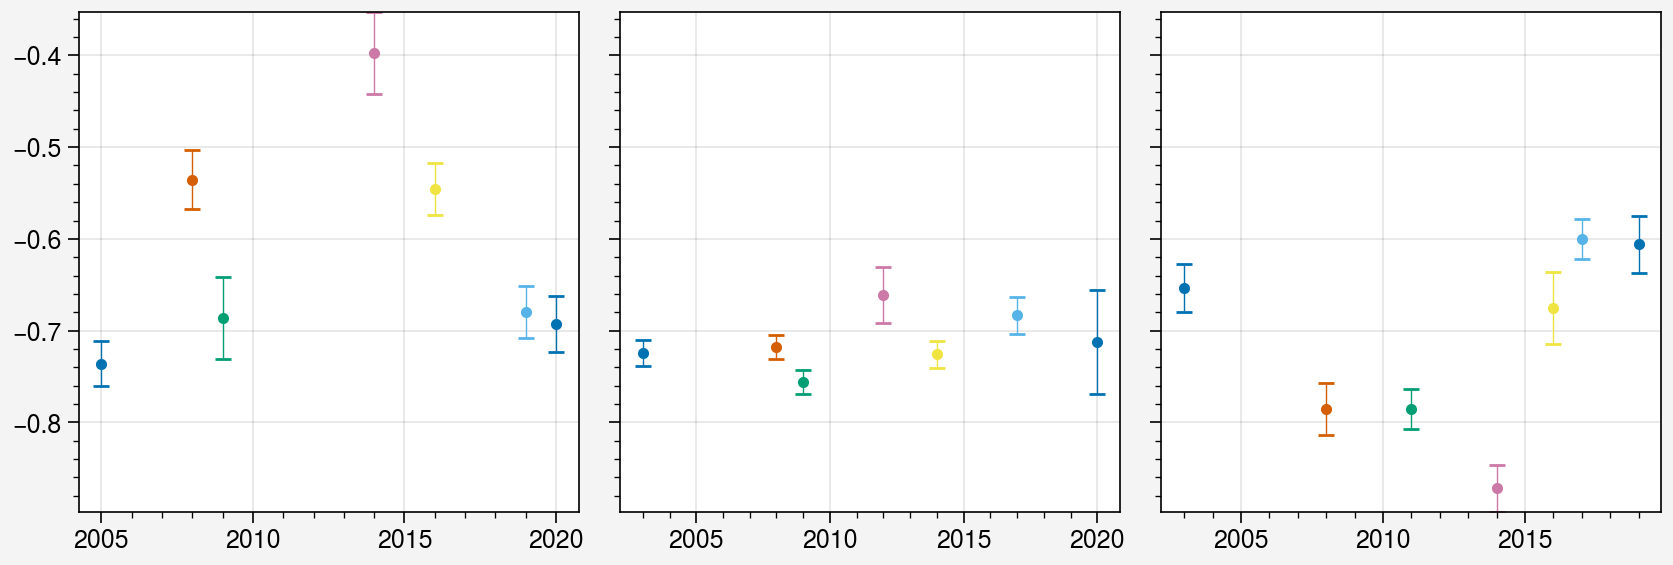

In [188]:
fig, axs = pplt.subplots(ncols=3)
for ax, month in zip(axs, range(4, 7)):
    for year in range(2003, 2021):
        data = all_results.loc[(all_results.datetime.dt.month == month) & (all_results.sampled)]
        data = data.loc[(data.datetime.dt.year == year)]
        data = data.loc[(data.log_bin > 0) & (data.log_bin < 10)]
        
        data_mean = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
        data_std = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
        n = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
        data_mean = data_mean.where(n['total_deformation'] > 50).dropna()
        data_std = data_std.where(n['total_deformation'] > 50).dropna()
        if len(data_mean) > 6:
            beta, a, r, p, err = linregress(np.log10(data_mean['L']), np.log10(data_mean['total_deformation']*24*60*60))
            
            ax.errorbar([year], [beta], lw=0.5, yerr=[err], marker='.')

In [190]:
strat_samp

,datetime,triangle_number,floe1,floe2,floe3,u1,u2,u3,v1,v2,...,y2,x3,y3,divergence,vorticity,pure_shear,normal_shear,total_deformation,month,year
2303593,2017-06-27 12:00:00,100,2017_06605,2017_06706,2017_06733,-0.06240,-0.02376,-0.03128,-0.12313,-0.06000,...,-1.243667e+06,800228.990369,-1.233436e+06,1.575616e-08,-7.786873e-06,-9.571678e-06,1.351285e-07,4.786316e-06,6,2017
547517,2004-06-06 12:00:00,145,2004_00866,2004_00917,2004_00871,-0.03536,0.01340,0.01526,0.05819,0.04256,...,-1.340278e+06,746372.657482,-1.283294e+06,7.226381e-07,-6.423151e-06,-5.815069e-06,6.353551e-06,4.306467e-06,6,2004
542489,2003-06-24 12:00:00,42,2003_06749,2003_07653,2003_07616,0.06358,0.00745,0.00706,-0.00163,0.02466,...,-1.071340e+06,628648.973907,-1.102096e+06,3.162246e-06,-1.809615e-06,-1.476308e-06,2.666603e-06,1.523996e-06,6,2003
1124256,2011-06-18 12:00:00,997,2011_01767,2011_02176,2011_01960,-0.04058,-0.10172,-0.00280,-0.12094,-0.04234,...,-1.170586e+06,811361.642999,-1.141728e+06,-2.394742e-06,-2.007667e-07,5.726732e-06,-1.710362e-06,2.988344e-06,6,2011
541978,2003-06-22 12:00:00,249,2003_07110,2003_07636,2003_07497,0.06898,0.05047,0.04365,0.09849,0.06193,...,-1.053084e+06,799213.953758,-1.091175e+06,1.270399e-06,1.275129e-06,2.422696e-06,1.255816e-07,1.212974e-06,6,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578283,2014-06-12 12:00:00,11138,2014_05841,2014_06058,2014_06123,0.00729,-0.04126,0.19339,-0.01203,-0.22351,...,-1.407251e+06,851885.810955,-1.060820e+06,1.442573e-06,-1.702346e-06,-7.513553e-07,7.152059e-07,5.186652e-07,6,2014
2637846,2019-06-14 12:00:00,8175,2019_04314,2019_04715,2019_05029,0.00437,-0.02720,-0.04884,-0.12465,-0.07141,...,-1.029972e+06,865034.034307,-7.423103e+05,9.283271e-08,1.485180e-06,1.354768e-06,-8.380519e-07,7.965122e-07,6,2019
1118480,2011-06-17 12:00:00,185,2011_01710,2011_01751,2011_02068,-0.06165,-0.06996,-0.02118,-0.03260,-0.07277,...,-1.043212e+06,719132.743611,-1.310161e+06,-4.863743e-07,-2.089590e-07,-2.928452e-07,-2.621101e-07,1.965070e-07,6,2011
1138043,2011-06-24 12:00:00,3165,2011_02529,2011_02589,2011_02612,0.13012,0.08335,-0.05788,-0.12784,0.04756,...,-1.237000e+06,800729.016800,-9.981294e+05,-2.206344e-06,3.589641e-07,3.881320e-07,-1.498049e-06,7.737567e-07,6,2011


In [16]:
df_100km.columns

Index(['datetime', 'triangle_number', 'floe1', 'floe2', 'floe3', 'u1', 'u2',
       'u3', 'v1', 'v2', 'v3', 'lat1', 'lat2', 'lat3', 'lon1', 'lon2', 'lon3',
       'area', 'min_angle', 'L', 'log_bin', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3',
       'divergence', 'vorticity', 'pure_shear', 'normal_shear',
       'total_deformation', 'month', 'year'],
      dtype='object')

In [19]:
df_ift = pd.read_csv('../data/floe_tracker/ift_with_era5.csv')

In [21]:
# Silly mistake - each floe has multiple distances.
# Need to index both by date and by floe.
# edge_dist = df_ift.loc[:, ['floe_id', 'edge_dist']].set_index('floe_id')


In [ ]:
import pandas as pd
df = pd.read_csv('../data/deformation/ift_deformation_calculations_2003.csv')

In [40]:
df = df.dropna(subset='divergence')

logbins = np.logspace(np.log(10), np.log(300), base=np.e, num=10)
df['L'] = np.sqrt(df['area_km2'])
df['log_bin'] = np.digitize(df['L'], logbins)


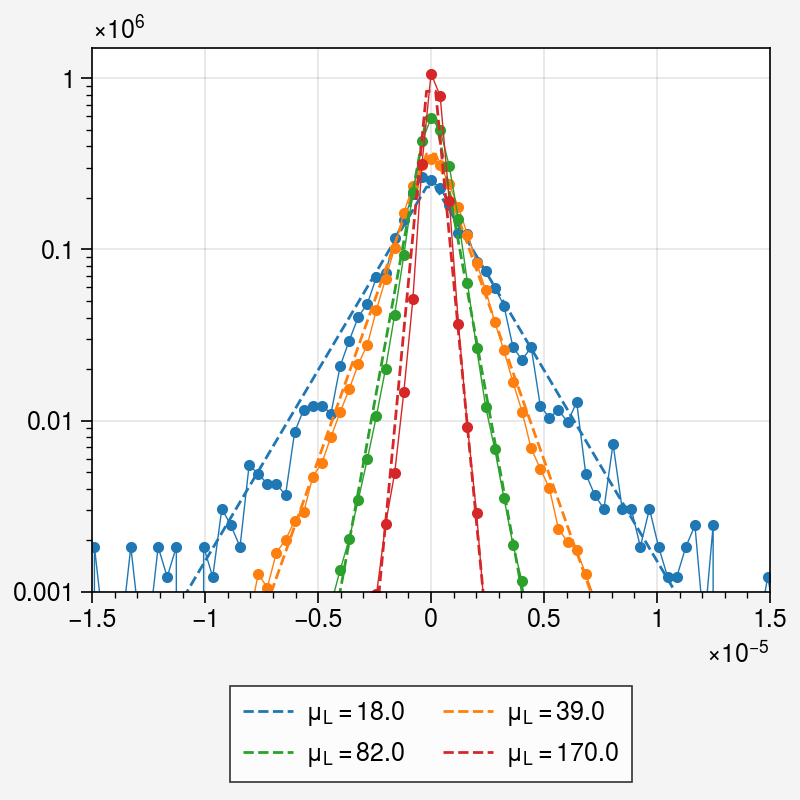

In [78]:
import scipy.stats as stats
var = 'divergence'
colors = pplt.Cycle('tab10', 8)
fig, ax = pplt.subplots(width=4, height=4)
for log_bin, c in zip(range(2, 10, 2), [x['color'] for x in colors]):
    ls = '--'
    if len(df.loc[df.log_bin==log_bin].dropna(subset=var)) > 500:
        
        train = df.loc[df.log_bin==log_bin].dropna(subset=var).sample(500, replace=False)
        # train[[var]] = train[[var]] / train[['length_bin', var]].groupby('length_bin').transform(lambda x: x.std())
        test =  df.loc[df.log_bin==log_bin].dropna(subset=var)
        test = test.loc[[x for x in test.index if x not in train.index], :]
        loc, scale = stats.expon.fit(np.abs(train[var]), floc=0)

        pdf, x_bins = np.histogram(test[var], bins=np.linspace(-3e-5, 3e-5, 150), density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        
        ax.plot(x_center, pdf, color=c, label='', marker='.', lw=0.5)
        
        x = np.linspace(-2e-5, 2e-5, 100)
        ax.plot(x, 0.5*stats.expon(loc=loc, scale=scale).pdf(np.abs(x)), ls=ls, c=c, lw=1,
                label='$\mu_L =$' + str(np.round(test['L'].mean())))
        ax.format(yscale='log', ylim=(1e3, 1.5e6), xlim=(-1.5e-5, 1.5e-5))
ax.legend(loc='b', ncols=2)

colors = pplt.Cycle('tab10', 10)
